# Using unsupervised and supervised machine learning to discover discrepancies between the two counter-circulating beams of the Large Hadron Collider

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker # for spacing out Fill number labels on x-axis
import pandas as pd
import math
import statistics
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import svm
from scipy.spatial.distance import cdist # for Euclidean distance
from mpl_toolkits.mplot3d import Axes3D

## Load data


This data must be available before running this notebook.  Run the `Data collection.ipynb` notebook to collect the data if it does not exist.

In [2]:
# Read saved DataFrames (result of Data collection notebook)
lossDfs = {
    'start_ramp': pd.read_pickle("data/pickles/startRampLosses.pkl"),
    'flat_top': pd.read_pickle("data/pickles/flatTopLosses.pkl"),
    'start_squeeze': pd.read_pickle("data/pickles/startSqueezeLosses.pkl"),
    'start_adjust': pd.read_pickle("data/pickles/startAdjustLosses.pkl")
}

# Copy timestamps column from the loss DataFrames
timestamps = {phaseName: lossDf['timestamp'] for phaseName, lossDf in lossDfs.items()}

# Remove timestamps column from the loss DataFrames so that it does not interfere (eg. with standardisation, clustering etc) 
for phaseName, lossDf in lossDfs.items():
    lossDf.drop(columns='timestamp', inplace=True)

## Preprocessing

### Check variances, range

In [3]:
def printMinMaxStdDev(lossDfs):
    """Prints the minimum and maximum feature standard deviation in lossDfs    
    
    Parameters
    ----------
    lossDfs : dict of str to DataFrame
        keys: phase name, values: loss DataFrame, without timestamps column, but otherwise identical in structure to the
        DataFrames saved by the Data Collection notebook.
    """
    for phaseName, lossDf in lossDfs.items():
        stds = lossDf.std().sort_values()
        
        print(phaseName)
        print(f'\t\tMin: {stds.keys()[0]}  {stds.iloc[0]}')
        print(f'\t\tMax: {stds.keys()[-1]}  {stds.iloc[-1]}')

In [4]:
def printMinMaxRange(lossDfs):
    """Prints the minimum and maximum feature range in lossDfs    
    
    Parameters
    ----------
    lossDfs : dict of str to DataFrame
        keys: phase name, values: loss DataFrame, without timestamps column, but otherwise identical in structure to the
        DataFrames saved by the Data Collection notebook.
    """
    for phaseName, lossDf in lossDfs.items():
        ranges = (lossDf.max() - lossDf.min()).sort_values()

        print(phaseName)
        print(f'\t\tMin: {ranges.keys()[0]}  {ranges.iloc[0]}')
        print(f'\t\tMax: {ranges.keys()[-1]}  {ranges.iloc[-1]}')

In [5]:
printMinMaxStdDev(lossDfs)

start_ramp
		Min: TCL.6x1  3.756342035149068e-08
		Max: TCP.6x3  0.037443085673988796
flat_top
		Min: TCL.6x1  1.225111181727108e-07
		Max: TCLA.A6x7  0.15853433213654786
start_squeeze
		Min: TCL.6x1  1.2364519340628526e-07
		Max: TCLA.A6x7  0.16196442637421815
start_adjust
		Min: TCTPV.4x2  1.1267715631305227e-06
		Max: TCLA.A6x7  0.09298262645223557


In [6]:
printMinMaxRange(lossDfs)

start_ramp
		Min: TCL.6x1  2.762e-07
		Max: TCP.6x3  0.2134994476
flat_top
		Min: TCL.6x1  7.043000000000001e-07
		Max: TCLA.A6x7  0.5663990085
start_squeeze
		Min: TCL.6x1  7.043000000000001e-07
		Max: TCLA.A6x7  0.5322993979
start_adjust
		Min: TCL.6x1  5.233999999999999e-06
		Max: TCLA.A6x7  0.48949871899999997


There is a large difference in order of magnitude in variance and range between the BLMs.  We must standardise the features so that BLMs with relatively high variance do not dominate the clustering and PCA calculations.

### Standardise data

According to https://maxwellsci.com/msproof.php?doi=rjaset.6.3638 standardisation is the most effective scaling technique before k-means.

TODO explain also that standardising is best before PCA (isn't it?) (as opposed to min-max etc.)
Standardising transforms the features into having zero mean and unit variance.  Since each feature will have the same variance (of 1), each feature will contribute equally to the PCA calculation.

In [7]:
# I tried these other two but didn't get any better accuracy really - on the full-feature space data.
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
scaler = StandardScaler()

for phaseName, lossDf in lossDfs.items():
    lossDf.loc[:] = scaler.fit_transform(lossDf.loc[:])

In [8]:
printMinMaxStdDev(lossDfs)

start_ramp
		Min: TCL.4x1  1.0016597521794572
		Max: TCTPV.4x5  1.0016597521794586
flat_top
		Min: TCDSB.4x6  1.0016597521794568
		Max: TCL.6x5  1.0016597521794586
start_squeeze
		Min: TCSG.E5x7  1.0021810276726821
		Max: TCSG.5x3  1.002181027672683
start_adjust
		Min: TCLA.A6x7  1.0020898664383395
		Max: TCP.B6x7  1.0020898664383406


In [9]:
printMinMaxRange(lossDfs)

start_ramp
		Min: TCL.4x5  3.965838864779768
		Max: TCTPH.4x2  16.874851934056302
flat_top
		Min: TCLA.A5x3  2.5507500758100665
		Max: TCDSB.4x6  16.602470355367135
start_squeeze
		Min: TCSG.4x3  3.0217066644042303
		Max: TCTPV.4x5  12.77146704588559
start_adjust
		Min: TCL.4x1  2.654624658530265
		Max: TCSP.A4x6_2  15.050276781466394


### Dimensionality reduction using PCA

#### Explained variance ratio bar chart

In [10]:
# METHOD 1 - separate bar chart for each phase
# pca = PCA()  # n_components not set => keep all components

# for phaseName, lossDf in lossDfs.items():
#     fig, ax = plt.subplots()

#     pca.fit(lossDf)
#     assert len(pca.explained_variance_ratio_) == len(lossDf.columns)
    
#     xs = np.arange(len(lossDf.columns))
    
#     ax.bar(xs, pca.explained_variance_ratio_, align='center', alpha=0.5, label=phaseName)
#     ax.set_ylabel('Explained variance ratio')
#     ax.set_xlabel('Principal components')
#     ax.legend()

<IPython.core.display.Javascript object>


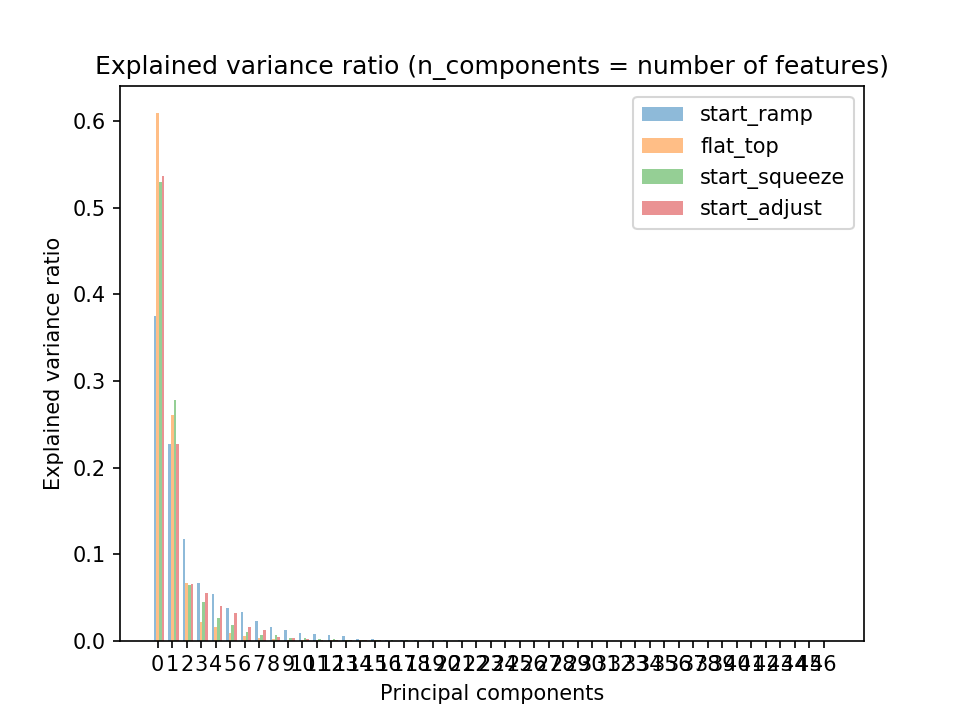

Variance explained by the first 3 principal components:
start_ramp	71.87%
flat_top	93.59%
start_squeeze	87.08%
start_adjust	82.97%


In [11]:
# METHOD 2 - one bar chart containing all 4 phases
pca = PCA()  # n_components not set => keep all components
fig, ax = plt.subplots()

# ensure that each lossDf in lossDfs has the same number of columns
assert len(set(map(lambda lossDf: len(lossDf.columns), lossDfs.values()))) == 1

xs = np.arange(len(lossDfs['start_ramp'].columns))
barWidth = 0.18

print('Variance explained by the first 3 principal components:')
for i, (phaseName, lossDf) in enumerate(lossDfs.items()):
    pca.fit(lossDf)
    assert len(pca.explained_variance_ratio_) == len(lossDf.columns)
    print(f'{phaseName}\t{sum(pca.explained_variance_ratio_[:3]):.2%}')
    
    ax.bar(xs + (i * barWidth), pca.explained_variance_ratio_, barWidth, alpha=0.5, label=phaseName)

ax.set_ylabel('Explained variance ratio')
ax.set_xlabel('Principal components')
ax.set_xticks(xs + barWidth)
ax.set_xticklabels(xs)
ax.set_title('Explained variance ratio (n_components = number of features)')
ax.legend()

####  Reducing to 3 dimensions

In [12]:
pca = PCA(n_components=3, whiten=True)
# From https://scikit-learn.org/stable/modules/decomposition.html#pca
# The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each 
# component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy 
# of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering 
# algorithm.
# I am using k-means clustering, and also DBSCAN, but not using the RBF kernel - using linear kernel for SVM.
# but I think this is also using Euclidean distance (to get best fit line / hyperplane) and therefore I think it is also
# assuming isotropy.

lossDfsPCA = {
    phaseName: pd.DataFrame(data=pca.fit_transform(lossDf), index=lossDf.index, columns=['PCA1', 'PCA2', 'PCA3'])
    for phaseName, lossDf in lossDfs.items()
}

# for phaseName, lossDf in lossDfsPCA.items():
#     lossDf.loc[:] = scaler.fit_transform(lossDf.loc[:])

Using PCA parameter `whiten=True`, we get unit variance.  This is useful for clustering algorithms (k-means, DBSCAN) that assume the signal is isotropic in all directions.

In [13]:
printMinMaxStdDev(lossDfsPCA)

start_ramp
		Min: PCA1  1.0000000000000002
		Max: PCA2  1.0000000000000004
flat_top
		Min: PCA2  1.0
		Max: PCA1  1.0000000000000007
start_squeeze
		Min: PCA3  1.0
		Max: PCA1  1.0000000000000013
start_adjust
		Min: PCA1  0.9999999999999998
		Max: PCA3  0.9999999999999999


In [14]:
printMinMaxRange(lossDfsPCA)

start_ramp
		Min: PCA1  5.833453829663215
		Max: PCA2  10.28773168376074
flat_top
		Min: PCA1  3.3740316096302987
		Max: PCA3  17.419858042487327
start_squeeze
		Min: PCA1  3.5551775358478928
		Max: PCA3  10.912864727707214
start_adjust
		Min: PCA1  4.045783097451641
		Max: PCA3  10.034931012938461


## Visualising the 3D PCA data

### Helper functions

In [15]:
def is3D(lossDf):
    """ Checks if lossDf has 3 features (3 columns).  Used to check if possible to make a 3D plot.
    
    Parameters
    ----------
    lossDf : DataFrame of floats
        loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
        
    Returns
    -------
    bool
    """
    
    return len(lossDf.columns) == 3

In [16]:
def scatterPlotLosses(lossDf, title="", ax=None):
    """ Makes a 3D scatter plot of the provided losses, with a legend denoting B1 and B2 losses.
    
    Parameters
    ----------
    lossDf : DataFrame of floats
        loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    title : str, optional
        The title to give the plot.  Defaults to the empty string.
    ax : Axes3D object, optional
        The axes on whih to draw the plot.  Defaults to none, in which case a new figure and Axes3d object will be made.
    """
    noExistingAxes = (ax == None)

    if noExistingAxes:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    
    xs = lossDf.loc['B1'][lossDf.columns[0]]
    ys = lossDf.loc['B1'][lossDf.columns[1]]
    zs = lossDf.loc['B1'][lossDf.columns[2]]
    ax.scatter(xs, ys, zs, c='red', label='B1')

    xs = lossDf.loc['B2'][lossDf.columns[0]]
    ys = lossDf.loc['B2'][lossDf.columns[1]]
    zs = lossDf.loc['B2'][lossDf.columns[2]]
    ax.scatter(xs, ys, zs, c='black', label='B2')

    ax.set_title(title)
    ax.set_xlabel(lossDf.columns[0])
    ax.set_ylabel(lossDf.columns[1])
    ax.set_zlabel(lossDf.columns[2])
    ax.add_artist(ax.legend(framealpha=0.5, loc="lower left"))
    
    if noExistingAxes:
        plt.show()

### Plotting

<IPython.core.display.Javascript object>


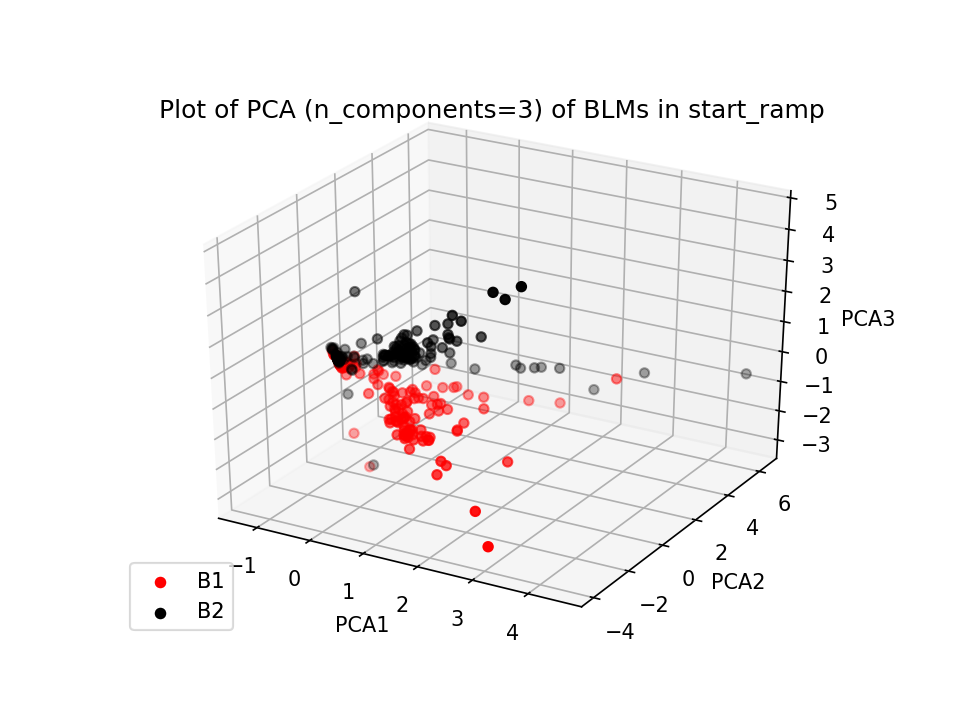

<IPython.core.display.Javascript object>


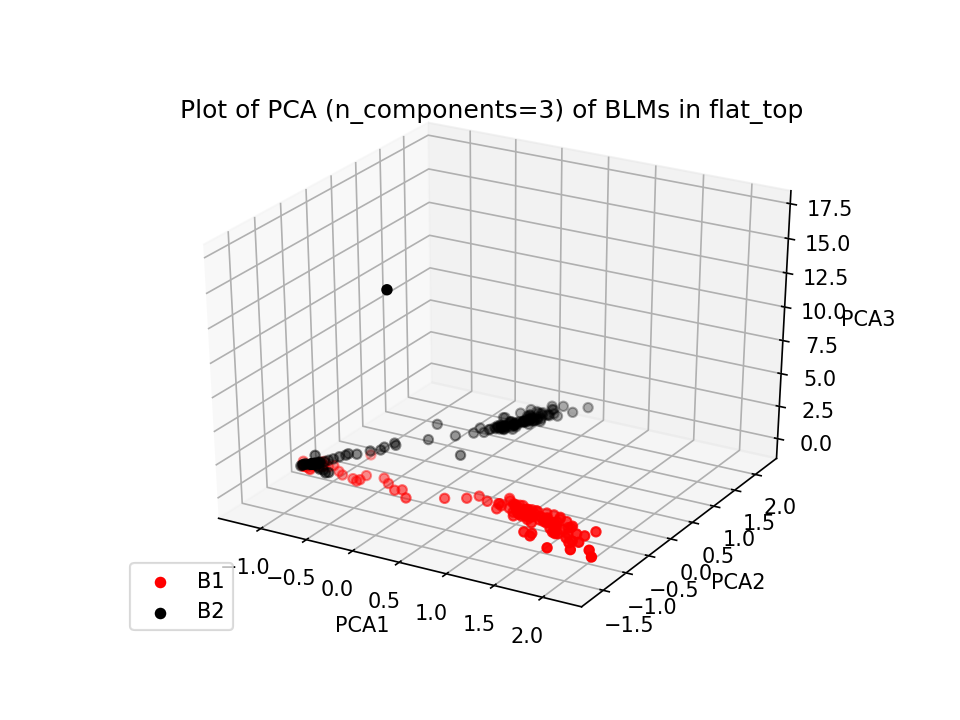

<IPython.core.display.Javascript object>


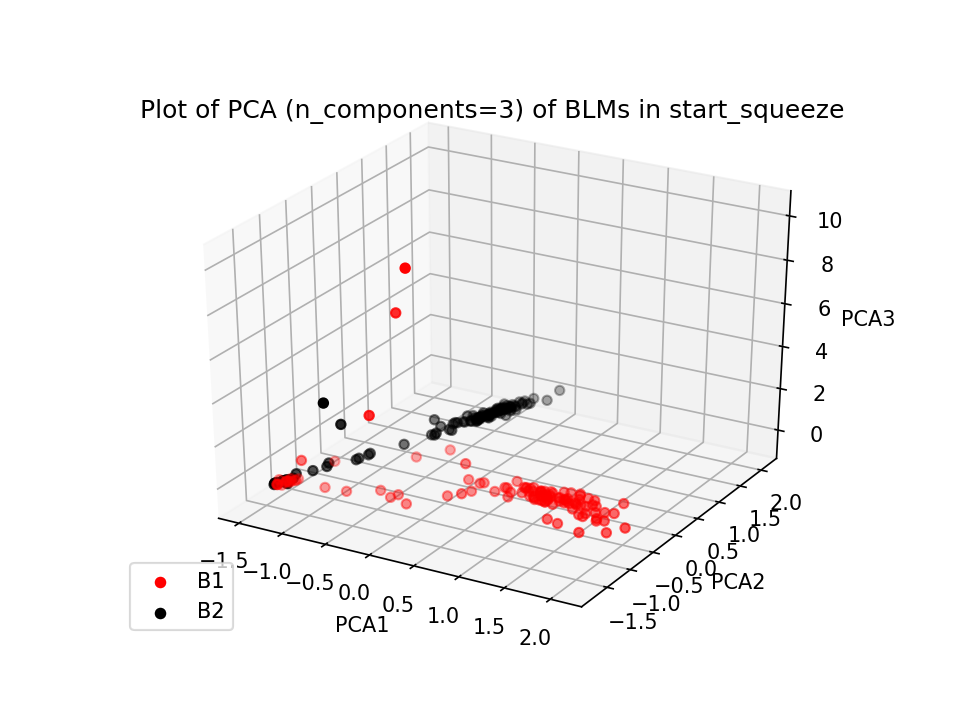

<IPython.core.display.Javascript object>


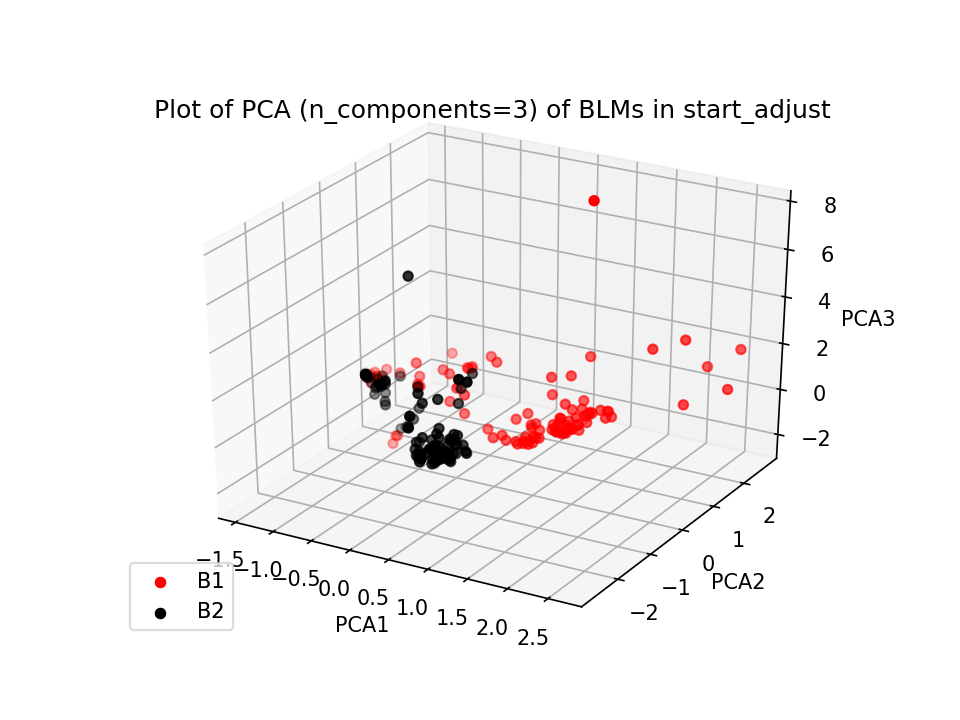

In [17]:
for phaseName, lossDf in lossDfsPCA.items():
    scatterPlotLosses(lossDf, f"Plot of PCA (n_components=3) of BLMs in {phaseName}")

## Euclidean distance

### Helper functions

To get Euclidean distance between the BLM vectors for beam 1 and beam 2

In [18]:
def getEuclideanDistance(lossDf):
    """
    Parameters
    ----------
    lossDf : DataFrame of floats
        Loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    
    Returns
    -------
    pandas.Series object
        Indexed by fill number, contains the Euclidean distance between each B1, B2 row of `lossDf` corresponding by
        fill number.
    """
    return pd.Series(cdist(lossDf.loc['B1'].values, lossDf.loc['B2'].values, metric='euclidean').diagonal(),
                     index=lossDf.loc['B1'].index) # to preserve the fill numbers for x-axis of the euclidean distance plot

# getting diagonal to get the euclidean distance of pairs of vectors we care about (i.e. corresponding rows)
# ie. euclidean distance between row 0 of B1 values, row 0 of B2 values; euclidean distance between row 1 of B1 values,
# row 1 of B2 values, and so on.

# to confirm values are correct:
# from scipy.spatial.distance import euclidean
# print(distance)
# print(euclidean(mergedPhaselossDf.loc['B1'].iloc[0], mergedPhaselossDf.loc['B2'].iloc[0]))
# print(euclidean(mergedPhaselossDf.loc['B1'].iloc[1], mergedPhaselossDf.loc['B2'].iloc[1]))
# ...

In [19]:
def plotEuclideanDistance(lossDfs, titleStr):
    distances = {phaseName: getEuclideanDistance(lossDf) for phaseName, lossDf in lossDfs.items()}
    
    fig, ax = plt.subplots()
    ax.set_yscale('log')

    for phaseName in distances:
        ax.plot(phaseName, data=distances, marker='x', label=phaseName)

    ax.set(xlabel='Fill',
           ylabel='Euclidean distance',
           title=titleStr)

    ax.legend()
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=15.0))  # set freqeuency of x-axis labels (fill numbers)

### Analysis

#### Full feature-space

<IPython.core.display.Javascript object>


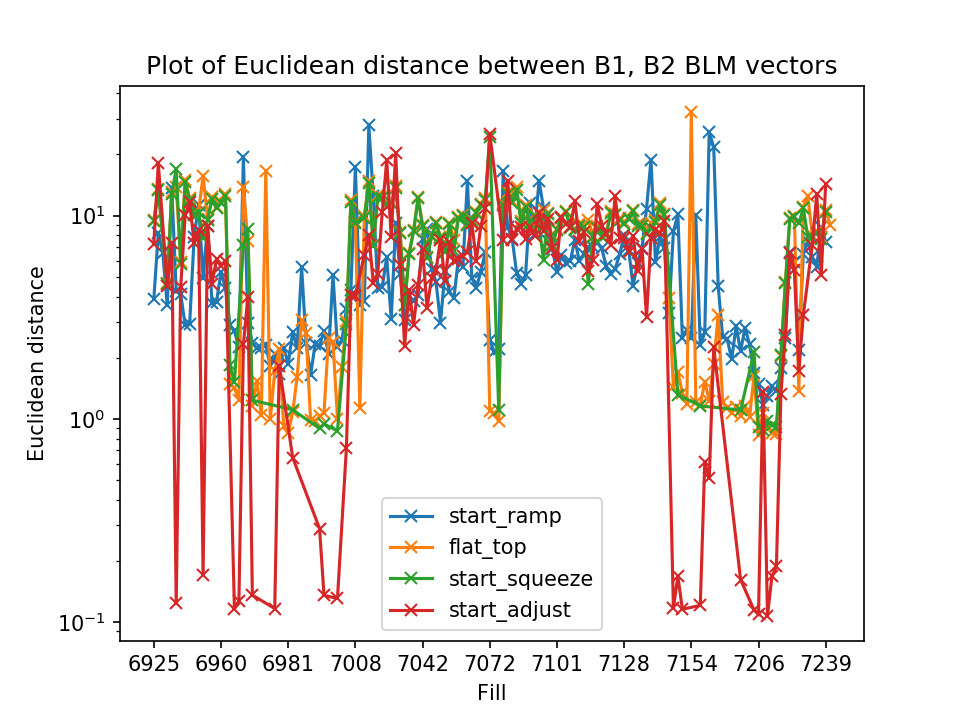

In [20]:
plotEuclideanDistance(lossDfs, 'Plot of Euclidean distance between B1, B2 BLM vectors')

#### PCA features

<IPython.core.display.Javascript object>


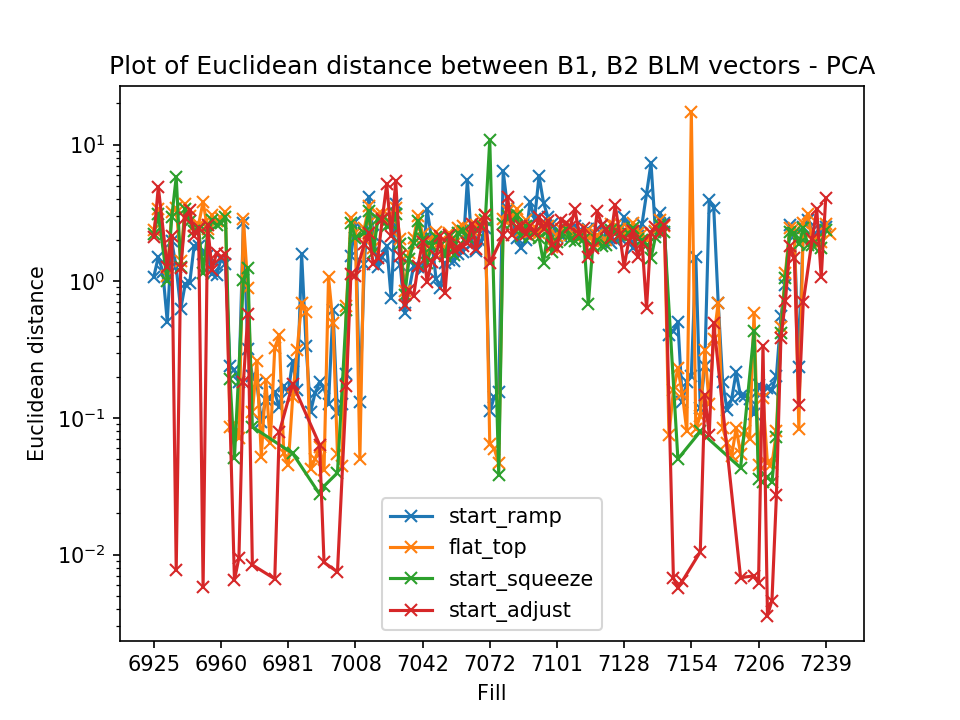

In [21]:
plotEuclideanDistance(lossDfsPCA, 'Plot of Euclidean distance between B1, B2 BLM vectors - PCA')

## Clustering classes and functions

In [22]:
class Cluster:
    """Used to hold information about a cluster.
    
    Attributes
    ----------
    clusterNo : int
        See __init__ parameter
    trainingSamplesCount : int
        number of samples (i.e. losses) used to perform the clustering
    b1Count : int
        number of beam 1 losses in the cluster
    b2Count : int
        number of beam 2 losses in the cluster
    size : int
        size of the cluster, i.e. number of losses in the cluster
    b1Proportion : float
        The proportion of beam 1 losses in the cluster i.e. b1Count / size
    b2Proportion : float
        The proportion of beam 2 losses in the cluster i.e. b2Count / size
    accuracy : float
        The maximum out of b1Proportion and b2Proportion - whichever is highest dictates which class the cluster represents
        (B1 or B2).  eg. if the cluster has b1Proportion > b2Proportion, then beam 2 points in this cluster are errors.
    timestampsStdDev : float
        The standard deviation of the timestamps of the losses in this cluster
    timestampsMean : float
        The mean of the timestamps of the losses in this cluster
    """
    def __init__(self, clusterNo, labels, timestamps):
        """Determines information about a cluster - size, proportion B1 and B2, accuracy, timestamp std dev and mean.
        
        Parameters
        ----------
        clusterNo : int
            Label of this cluster, taken from the labels list returned by the scikit-learn clustering method
        labels : list of int
            Cluster labels returned by the scikit-learn clustering method.  There should be an element (i.e. a label)
            for every training sample.
        timestamps : Series of float
            Timestamps corresponding to each training sample.
        """
        
        self.clusterNo = clusterNo
        self.trainingSamplesCount = len(labels)
        
        # split labels into two halves - the first half corresponds to B1 losses, the second half to B2 losses
        # (this is how the losses DataFrames are organised)
        assert len(labels) % 2 == 0
        b1Labels = list(labels[: len(labels)//2])
        b2Labels = list(labels[len(labels)//2 :])
        
        # count number of times this clusterNo appears in the B1, B2 part of labels
        self.b1Count = b1Labels.count(clusterNo)
        self.b2Count = b2Labels.count(clusterNo)
        self.size = self.b1Count + self.b2Count
        
        self.b1Proportion = self.b1Count / self.size
        self.b2Proportion = self.b2Count / self.size
        self.accuracy = max(self.b1Proportion, self.b2Proportion)
        
        # calculate standard deviation and mean of timestamps of losses in this cluster
        lossesInClusterIndices = np.where(labels == clusterNo)[0]
        timestamps = timestamps.iloc[lossesInClusterIndices]
        
        self.timestampsStdDev = timestamps.std()
        if math.isnan(self.timestampsStdDev):  # Series.std() return Nan when there is only one value in the cluster
            self.timestampsStdDev = 0
        
        self.timestampsMean = timestamps.mean()
        
    def describe(self):
        """Prints the cluster label, size, B1-B2 proportions, and timestamps std dev and mean."""
        
        print((f'\tCluster {self.clusterNo} has {(self.size / self.trainingSamplesCount):.2%}'
                f' ({self.size} / {self.trainingSamplesCount}) of the losses, of which:'))
        print(f'\t\t\t{self.b1Proportion:.2%} are B1, \t{self.b2Proportion:.2%} are B2\n')
        print(f'\t\tTimestamps std dev = {str(datetime.timedelta(self.timestampsStdDev))}')
        print(f"\t\tTimestamps mean = {pd.Timestamp(self.timestampsMean, unit='s')}\n")

In [23]:
class ClusteringResult:
    """Used to hold information about a clustering result (i.e. the labels returned by a clustering method eg. KMeans, DBSCAN)
    
    Attributes
    ----------
    labels : list of int
        See __init__ parameter
    clusters : dict of int to Cluster objects
        key is cluster number (taken from labels), value is the corresponding Cluster object
    averageAccuracy : float
        The average of the clusters' accuracies
    """
    def __init__(self, labels, timestamps):
        """Instantiates Cluster objects for each of the clusters in labels.  Calculates the average accuracy.
        
        Note:  Loops from min cluster label to max cluster label in order to instantiate each Cluster.
        
        Parameters
        ----------
        labels : list of int
            Cluster labels returned by a scikit-learn clustering method.  There should be an element (i.e. a label)
            for every training sample (i.e. every row in the losses DataFrame)
        timestamps : Series of float
            Timestamps corresponding to each training sample.
        """
        self.labels = labels
        self.clusters = {}
        
        # instantiate a Cluster object for each unique cluster label in labels
        for clusterNo in range(min(labels), max(labels) + 1):
            self.clusters[clusterNo] = Cluster(clusterNo, labels, timestamps)
        
        # assert that the sum of the sizes of each cluster adds up to the number of training samples, to ensure that
        # every training sample was assigned a cluster
        sizes = list(map(lambda cluster: cluster.size, self.clusters.values()))
        assert sum(sizes) == len(labels) 
        
        accuracies = list(map(lambda cluster: cluster.accuracy, self.clusters.values()))
        self.averageAccuracy = sum(accuracies) / len(accuracies)
        
    def describe(self):
        """Prints the average accuracy, and calls each Cluster's describe() method"""
        
        print(f'\tAverage accuracy = {self.averageAccuracy:.2%}\n')
        for cluster in self.clusters.values():
            cluster.describe()

In [24]:
def scatterPlotClusters(lossDf, labels, title=""):   
    """ Makes two 3D scatter plots of lossesDf side by side: one showing clusters, the other showing the ground truth.
    
    Parameters
    ----------
    lossDf : DataFrame of floats
        Loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    labels : list of int 
        Cluster labels returned by a scikit-learn clustering method.  There should be an element (i.e. a label)
        for every training sample (i.e. every row in lossDf)
    title : str, optional
        The title to give the plot.  Defaults to the empty string.
    """
    assert len(lossDf) == len(labels)

    fig = plt.figure(figsize=plt.figaspect(0.5))  # make the figure half as tall as it is wide
    
    # Clusters subplot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title(title)
    scatter = ax.scatter(lossDf[lossDf.columns[0]], lossDf[lossDf.columns[1]], lossDf[lossDf.columns[2]],
               c=labels)
    ax.set_xlabel(lossDf.columns[0])
    ax.set_ylabel(lossDf.columns[1])
    ax.set_zlabel(lossDf.columns[2])
    
    ax.add_artist(ax.legend(*scatter.legend_elements(), title="Clusters", loc="lower left", framealpha=0.5))
    
    # Ground truth subplot
    scatterPlotLosses(lossDf, "Ground truth", fig.add_subplot(1, 2, 2, projection='3d'))
    
    plt.show()

## KMeans clustering

### Helper functions

In [25]:
def kmeansAnalysis(kmeans, lossDf, timestamps, phaseName, runCount=10):
    """ Runs kmeans on lossDf, displaying the worst and best performing result.
    
    Clustering result can change depending on initial centroid - therefore kmeans is run `runCount` times. 
    
    Plots are only done if lossDf is 3D.
    
    Parameters
    ----------
    kmeans : sklearn.cluster.KMeans object
    lossDf : DataFrame of floats
        Loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    timestamps : Series of float
            Timestamps corresponding to each training sample in lossDf
    phaseName : str
    runCount : int, optional
        Number of times to run kmeans on the given lossDf.  Defaults to 10.
    """
    results = []

    for i in range(0, runCount):
        labels = kmeans.fit_predict(lossDf)
        results.append(ClusteringResult(labels, timestamps))
        
    # average accuracy of each k-means run
    averageAccuracies = list(map(lambda result: result.averageAccuracy, results))
    
    print(f'Accuracies std dev = {statistics.stdev(averageAccuracies)}')
    print(f'Accuracies mean = {statistics.mean(averageAccuracies)}\n')
        
    print('Worst performing clustering result:')
    worstResultIdx = averageAccuracies.index(min(averageAccuracies))
    results[worstResultIdx].describe()
        
    if is3D(lossDf):
        scatterPlotClusters(lossDf, results[worstResultIdx].labels, f"k-means clusters of {phaseName} - worst accuracy")
    
    print('Best performing clustering result:')
    bestResultIdx = averageAccuracies.index(max(averageAccuracies))
    results[bestResultIdx].describe()
        
    if is3D(lossDf):
        scatterPlotClusters(lossDf, results[bestResultIdx].labels, f"k-means clusters of {phaseName} - best accuracy")

### Analysis

In [26]:
kmeans = KMeans(n_clusters = 2)
#n_init parameter default=10, meaning the "number of times the k-means algorithm will be run with different centroid seeds.
#The final results will be the best output of n_init consecutive runs in terms of inertia." (docs)

#### On full feature-space

In [27]:
for phaseName, lossDf in lossDfs.items():
    print(phaseName)
    kmeansAnalysis(kmeans, lossDf, timestamps[phaseName], phaseName)

start_ramp
Accuracies std dev = 0.0
Accuracies mean = 0.5067798132183908

Worst performing clustering result:
	Average accuracy = 50.68%

	Cluster 0 has 42.38% (128 / 302) of the losses, of which:
			49.22% are B1, 	50.78% are B2

		Timestamps std dev = 2243272 days, 6:21:21.021899
		Timestamps mean = 2018-08-18 06:45:09.102421522

	Cluster 1 has 57.62% (174 / 302) of the losses, of which:
			50.57% are B1, 	49.43% are B2

		Timestamps std dev = 1762449 days, 4:02:39.834746
		Timestamps mean = 2018-08-22 04:45:58.681091309

Best performing clustering result:
	Average accuracy = 50.68%

	Cluster 0 has 42.38% (128 / 302) of the losses, of which:
			49.22% are B1, 	50.78% are B2

		Timestamps std dev = 2243272 days, 6:21:21.021899
		Timestamps mean = 2018-08-18 06:45:09.102421522

	Cluster 1 has 57.62% (174 / 302) of the losses, of which:
			50.57% are B1, 	49.43% are B2

		Timestamps std dev = 1762449 days, 4:02:39.834746
		Timestamps mean = 2018-08-22 04:45:58.681091309

flat_top
Accura

#### On PCA features

start_ramp - PCA
Accuracies std dev = 0.007518934201694802
Accuracies mean = 0.7947337430372425

Worst performing clustering result:
	Average accuracy = 79.24%

	Cluster 0 has 67.88% (205 / 302) of the losses, of which:
			31.22% are B1, 	68.78% are B2

		Timestamps std dev = 2059831 days, 22:08:08.565029
		Timestamps mean = 2018-08-21 02:38:36.833023787

	Cluster 1 has 32.12% (97 / 302) of the losses, of which:
			89.69% are B1, 	10.31% are B2

		Timestamps std dev = 1819490 days, 1:26:33.555938
		Timestamps mean = 2018-08-19 07:54:53.039690495



<IPython.core.display.Javascript object>


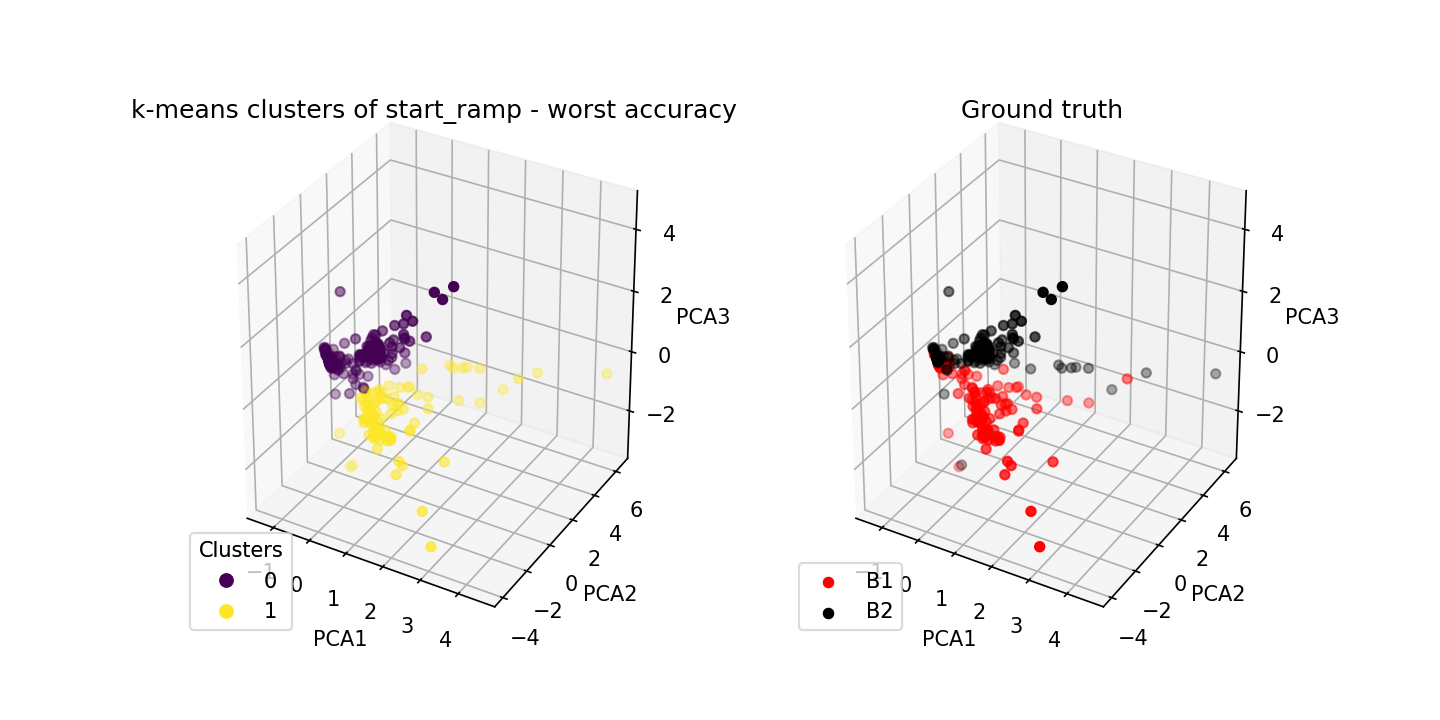

Best performing clustering result:
	Average accuracy = 81.61%

	Cluster 0 has 23.18% (70 / 302) of the losses, of which:
			98.57% are B1, 	1.43% are B2

		Timestamps std dev = 1574273 days, 3:39:48.439026
		Timestamps mean = 2018-08-26 11:41:58.369285107

	Cluster 1 has 76.82% (232 / 302) of the losses, of which:
			35.34% are B1, 	64.66% are B2

		Timestamps std dev = 2070033 days, 5:08:35.695205
		Timestamps mean = 2018-08-18 17:50:21.076594353



<IPython.core.display.Javascript object>


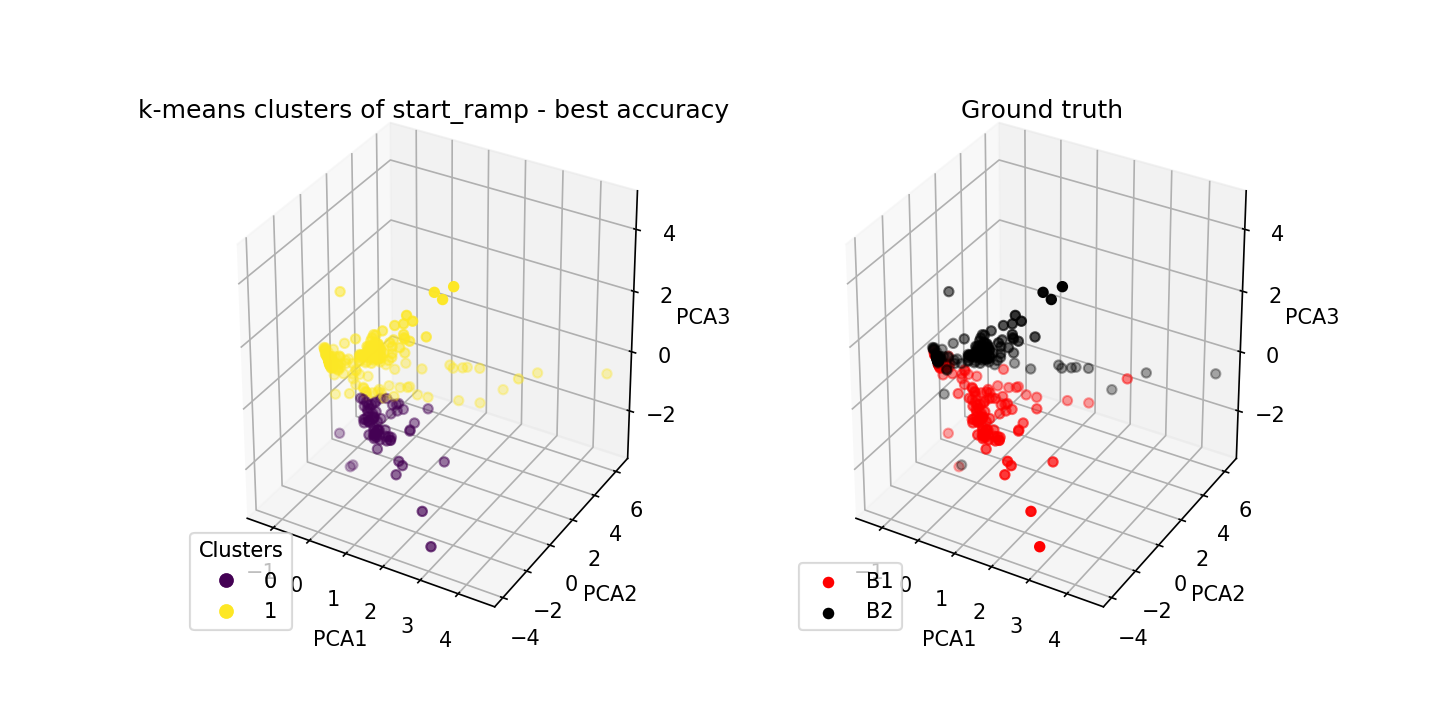

flat_top - PCA
Accuracies std dev = 0.05496236680436248
Accuracies mean = 0.8146866030932689

Worst performing clustering result:
	Average accuracy = 75.08%

	Cluster 0 has 99.67% (301 / 302) of the losses, of which:
			50.17% are B1, 	49.83% are B2

		Timestamps std dev = 1989169 days, 9:15:01.378716
		Timestamps mean = 2018-08-20 23:38:31.782691717

	Cluster 1 has 0.33% (1 / 302) of the losses, of which:
			0.00% are B1, 	100.00% are B2

		Timestamps std dev = 0:00:00
		Timestamps mean = 2018-09-12 20:39:06.750000



<IPython.core.display.Javascript object>


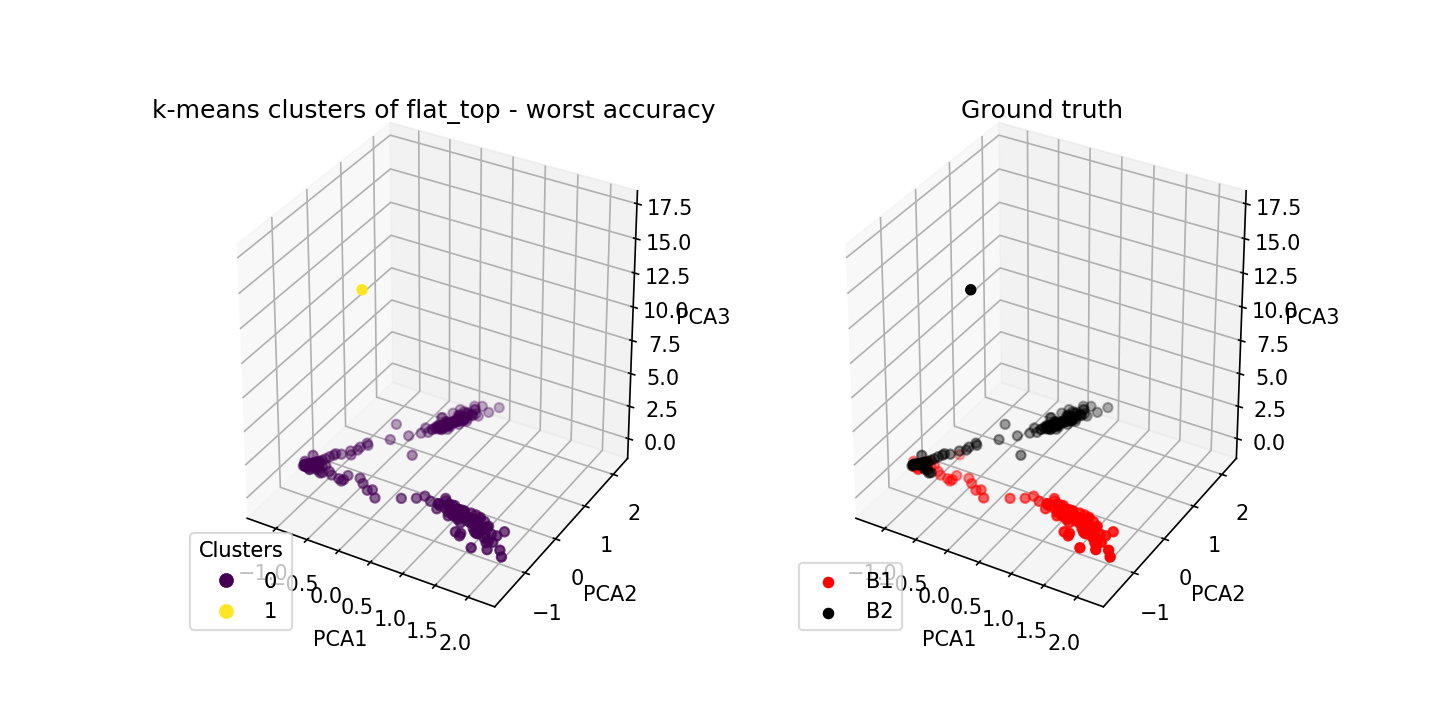

Best performing clustering result:
	Average accuracy = 85.78%

	Cluster 0 has 30.13% (91 / 302) of the losses, of which:
			0.00% are B1, 	100.00% are B2

		Timestamps std dev = 1809094 days, 21:05:17.558386
		Timestamps mean = 2018-08-21 01:51:20.150768995

	Cluster 1 has 69.87% (211 / 302) of the losses, of which:
			71.56% are B1, 	28.44% are B2

		Timestamps std dev = 2066026 days, 1:12:09.046324
		Timestamps mean = 2018-08-21 01:17:22.178294420



<IPython.core.display.Javascript object>


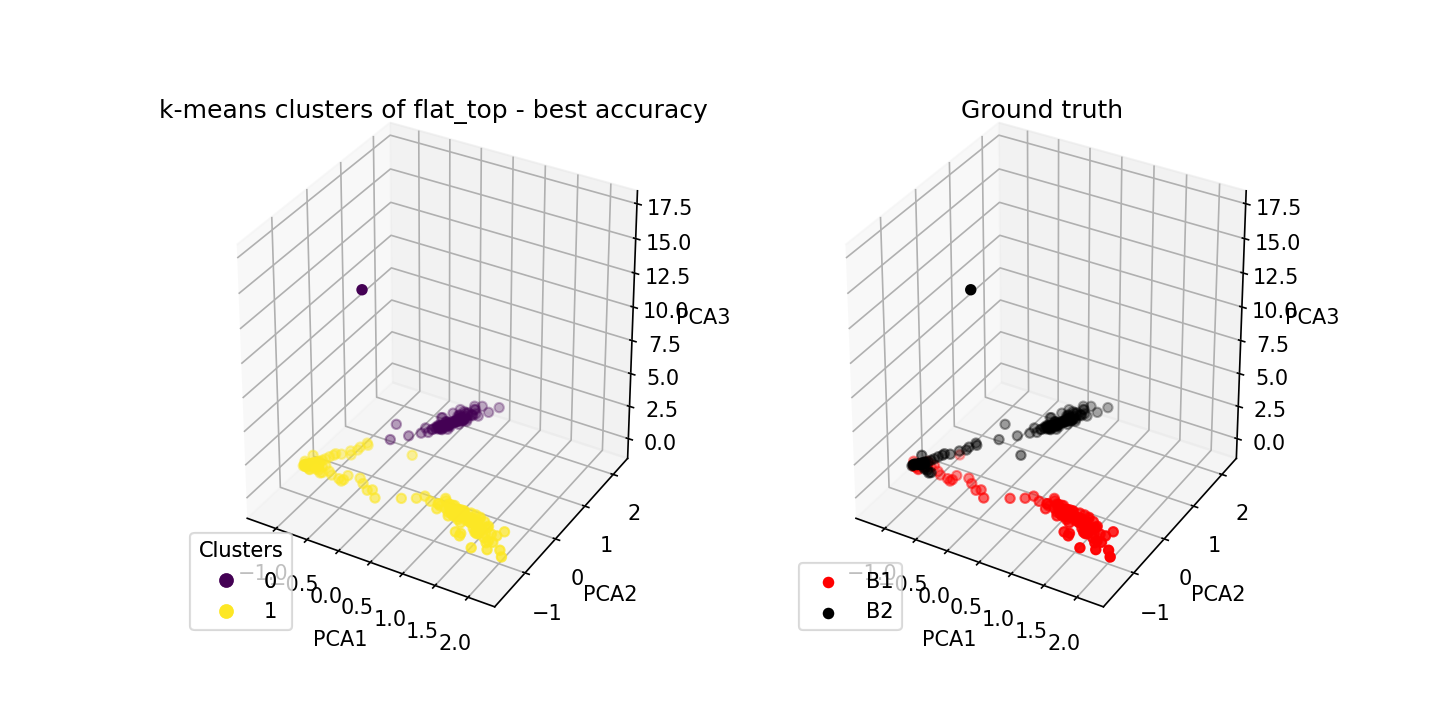

start_squeeze - PCA
Accuracies std dev = 0.0018036102312124346
Accuracies mean = 0.9026682537320835

Worst performing clustering result:
	Average accuracy = 90.21%

	Cluster 0 has 62.17% (143 / 230) of the losses, of which:
			80.42% are B1, 	19.58% are B2

		Timestamps std dev = 2047248 days, 4:04:07.973576
		Timestamps mean = 2018-08-21 03:05:04.246503353

	Cluster 1 has 37.83% (87 / 230) of the losses, of which:
			0.00% are B1, 	100.00% are B2

		Timestamps std dev = 1745463 days, 6:54:05.469441
		Timestamps mean = 2018-08-21 02:33:17.141264200



<IPython.core.display.Javascript object>


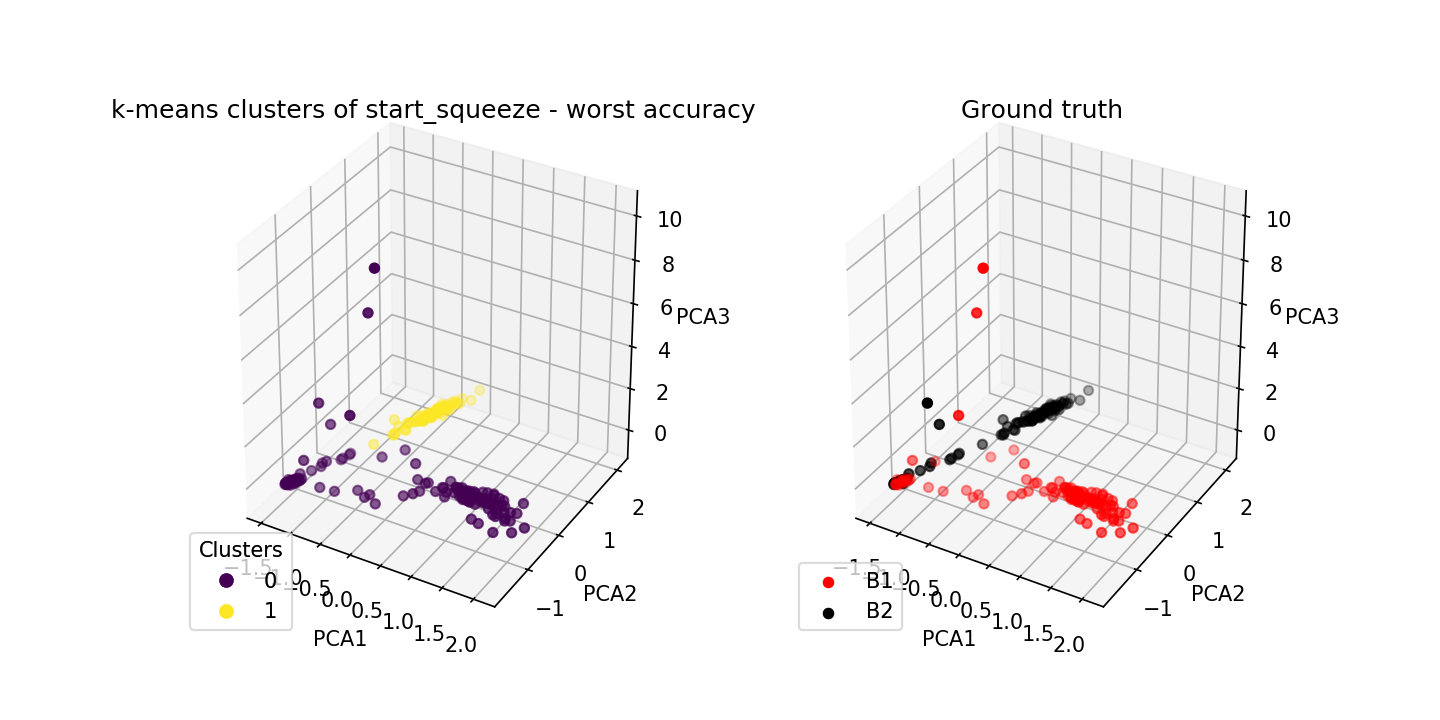

Best performing clustering result:
	Average accuracy = 90.78%

	Cluster 0 has 38.70% (89 / 230) of the losses, of which:
			100.00% are B1, 	0.00% are B2

		Timestamps std dev = 1782121 days, 19:43:50.193103
		Timestamps mean = 2018-08-20 04:21:23.124381781

	Cluster 1 has 61.30% (141 / 230) of the losses, of which:
			18.44% are B1, 	81.56% are B2

		Timestamps std dev = 2029648 days, 10:57:00.941459
		Timestamps mean = 2018-08-21 17:06:13.478510380



<IPython.core.display.Javascript object>


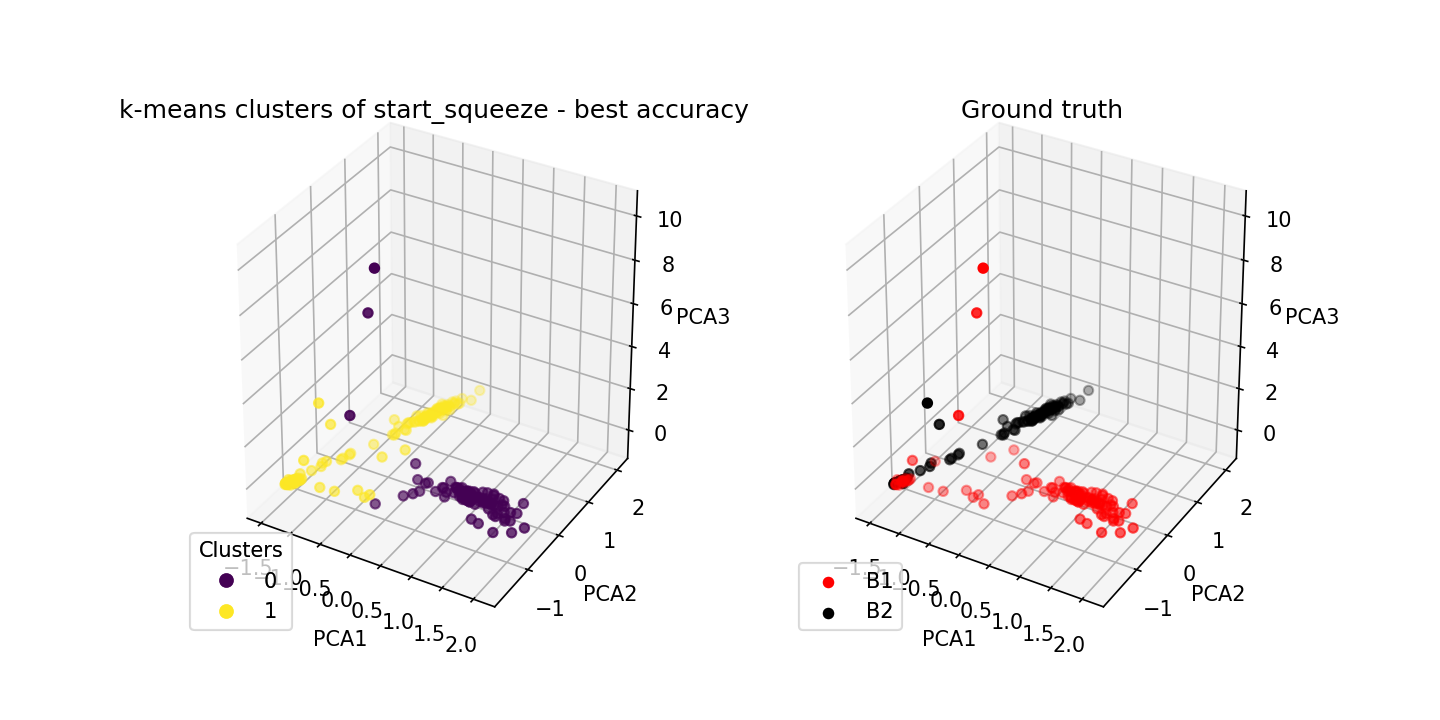

start_adjust - PCA
Accuracies std dev = 0.0
Accuracies mean = 0.5085714285714286

Worst performing clustering result:
	Average accuracy = 50.86%

	Cluster 0 has 58.33% (140 / 240) of the losses, of which:
			49.29% are B1, 	50.71% are B2

		Timestamps std dev = 1533719 days, 0:56:37.218950
		Timestamps mean = 2018-08-20 14:10:01.760000229

	Cluster 1 has 41.67% (100 / 240) of the losses, of which:
			51.00% are B1, 	49.00% are B2

		Timestamps std dev = 2398970 days, 12:57:17.749086
		Timestamps mean = 2018-08-22 10:57:33.055999994



<IPython.core.display.Javascript object>


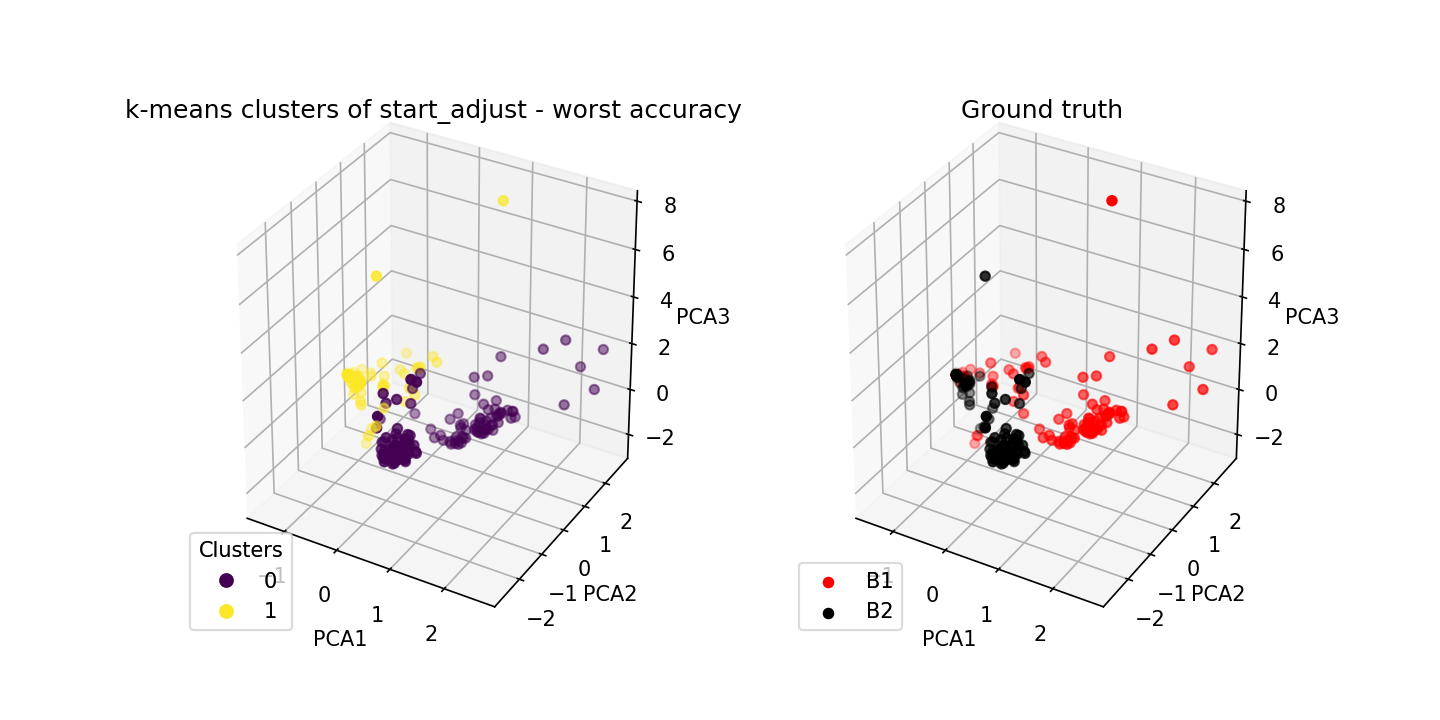

Best performing clustering result:
	Average accuracy = 50.86%

	Cluster 0 has 58.33% (140 / 240) of the losses, of which:
			49.29% are B1, 	50.71% are B2

		Timestamps std dev = 1533719 days, 0:56:37.218950
		Timestamps mean = 2018-08-20 14:10:01.760000229

	Cluster 1 has 41.67% (100 / 240) of the losses, of which:
			51.00% are B1, 	49.00% are B2

		Timestamps std dev = 2398970 days, 12:57:17.749086
		Timestamps mean = 2018-08-22 10:57:33.055999994



<IPython.core.display.Javascript object>


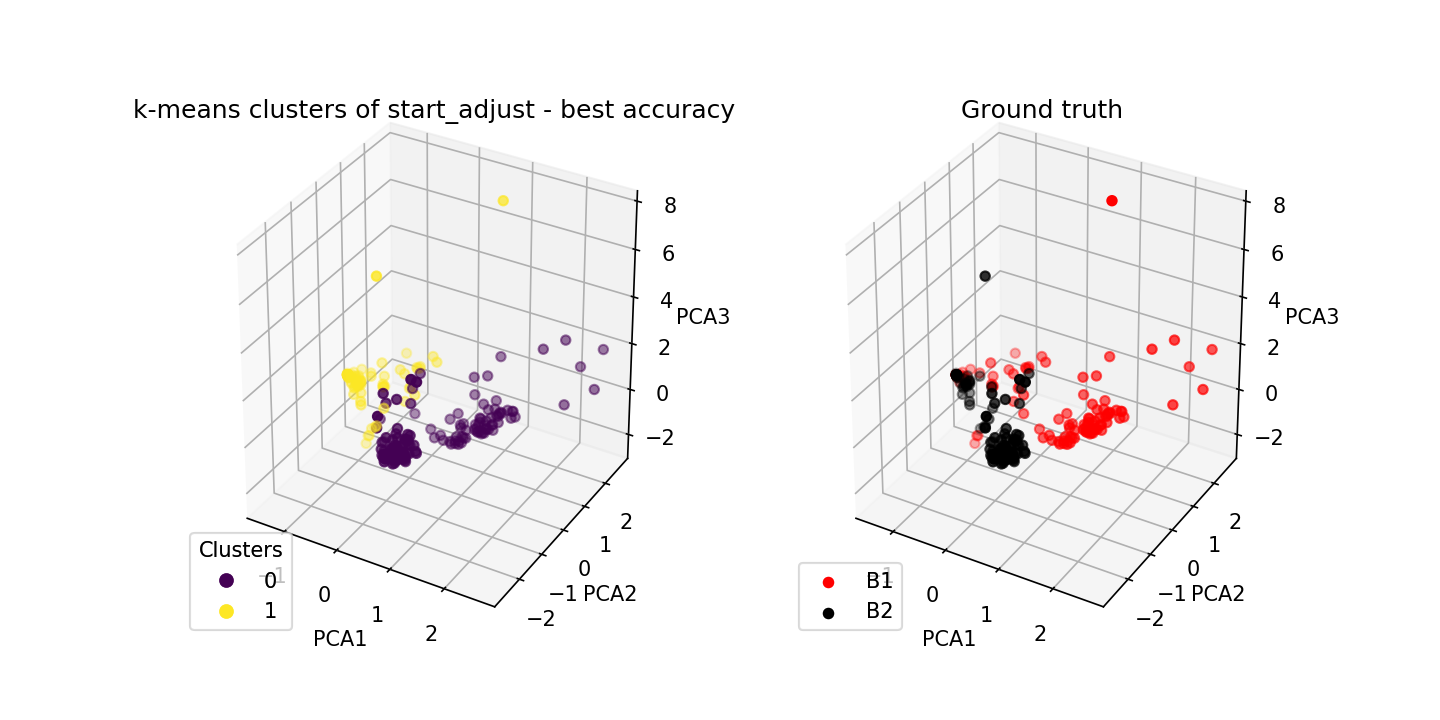

In [28]:
for phaseName, lossDf in lossDfsPCA.items():  
    print(f'{phaseName} - PCA')
    kmeansAnalysis(kmeans, lossDf, timestamps[phaseName], phaseName)

## DBSCAN



### Helper functions

In [29]:
def dbscanAnalysis(dbscan, lossDf, timestamps, phaseName):
    """ Runs DBSCAN on lossDf and displays clustering info.
    
    Plots are only done if lossDf is 3D.
    
    Parameters
    ----------
    dbscan : sklearn.cluster.DBSCAN object
    lossDf : DataFrame of floats
        Loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    timestamps : Series of float
            Timestamps corresponding to each training sample in lossDf
    phaseName : str
    """
    labels = dbscan.fit_predict(lossDf)
    
    clusteringResult = ClusteringResult(labels, timestamps)
    clusteringResult.describe()
    
    if is3D(lossDf):
        scatterPlotClusters(lossDf, labels, f"DBSCAN clusters of {phaseName}")

### Analysis

In [30]:
# eps - "The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not
#        a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose 
#        appropriately for your data set and distance function."
# min_samples - "The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
#                This includes the point itself."

# min samples: can go from 5% of the data set size up to 30%.  
# don't forget this is a MINIMUM. it's not THE number of points in each cluster
# -- Do a loop, try out differnt vslues of min neighbours

# eps: after doing scaling, print out the max and min in the dataframe.  
#     will give indication of eps.  or choose eps to match ground truth.
# ? what is eps ground truth?

dbscan = DBSCAN(eps=0.5, min_samples=15) # these params worked when PCA whiten=True
# dbscan = DBSCAN(eps=1.4, min_samples=15)
                                        # if whiten=False, try eps=1, min_samples=6 and eps=1.4, min=15 - 5% of startRamp len
                                        # looks like if min_samples goes up, eps must also ... otherwise we are expecting
        # a very dense neighbourhood for a point to be a core point if we have a small eps (radius) and a high min_samples.
        # eg. eps=0.3, min_samples=6 worked (PCA whiten=True).  but boosting min_samples to 15, I also boosted eps to 0.5
        # and this gave me the "nicest" result yet
# from Wikipedia = as a rule of thumb, 2*dimensions (2*3 = 6) can be used

#### Full feature-space

In [31]:
for phaseName, lossDf in lossDfs.items():
    print(phaseName)
    dbscanAnalysis(dbscan, lossDf, timestamps[phaseName], phaseName)

start_ramp
	Average accuracy = 50.00%

	Cluster -1 has 100.00% (302 / 302) of the losses, of which:
			50.00% are B1, 	50.00% are B2

		Timestamps std dev = 1984092 days, 8:31:58.388823
		Timestamps mean = 2018-08-20 12:55:09.853047848

flat_top
	Average accuracy = 83.54%

	Cluster -1 has 81.13% (245 / 302) of the losses, of which:
			49.39% are B1, 	50.61% are B2

		Timestamps std dev = 1981267 days, 19:59:11.337010
		Timestamps mean = 2018-08-21 01:00:14.700450182

	Cluster 0 has 9.93% (30 / 302) of the losses, of which:
			100.00% are B1, 	0.00% are B2

		Timestamps std dev = 2047974 days, 2:08:46.905102
		Timestamps mean = 2018-08-20 14:34:49.196666718

	Cluster 1 has 8.94% (27 / 302) of the losses, of which:
			0.00% are B1, 	100.00% are B2

		Timestamps std dev = 2069543 days, 5:34:44.084143
		Timestamps mean = 2018-08-21 17:41:10.956666708

start_squeeze
	Average accuracy = 50.00%

	Cluster -1 has 100.00% (230 / 230) of the losses, of which:
			50.00% are B1, 	50.00% are B2

		T

#### PCA features

start_ramp - PCA
	Average accuracy = 75.29%

	Cluster -1 has 19.21% (58 / 302) of the losses, of which:
			41.38% are B1, 	58.62% are B2

		Timestamps std dev = 1984655 days, 18:56:33.960971
		Timestamps mean = 2018-08-16 12:23:10.346723795

	Cluster 0 has 23.18% (70 / 302) of the losses, of which:
			100.00% are B1, 	0.00% are B2

		Timestamps std dev = 1715967 days, 0:23:56.762696
		Timestamps mean = 2018-08-22 09:08:56.038713932

	Cluster 1 has 57.62% (174 / 302) of the losses, of which:
			32.76% are B1, 	67.24% are B2

		Timestamps std dev = 2079335 days, 11:23:44.028902
		Timestamps mean = 2018-08-21 03:18:13.177010298



<IPython.core.display.Javascript object>


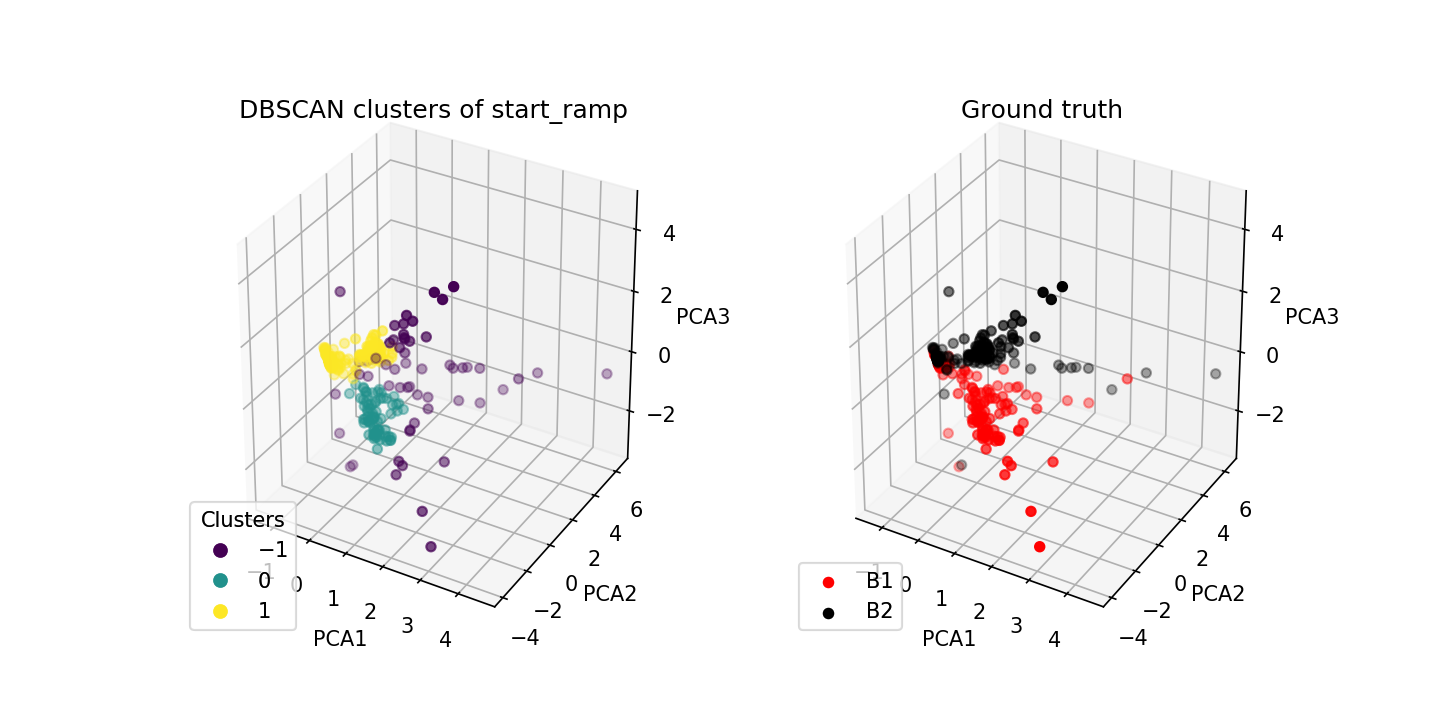

flat_top - PCA
	Average accuracy = 82.71%

	Cluster -1 has 1.66% (5 / 302) of the losses, of which:
			20.00% are B1, 	80.00% are B2

		Timestamps std dev = 1944732 days, 11:44:30.049623
		Timestamps mean = 2018-08-06 23:55:13.849999905

	Cluster 0 has 29.80% (90 / 302) of the losses, of which:
			100.00% are B1, 	0.00% are B2

		Timestamps std dev = 1807090 days, 11:58:53.358197
		Timestamps mean = 2018-08-20 19:46:48.299666405

	Cluster 1 has 39.07% (118 / 302) of the losses, of which:
			50.85% are B1, 	49.15% are B2

		Timestamps std dev = 2240085 days, 14:33:32.286343
		Timestamps mean = 2018-08-21 22:27:03.187033415

	Cluster 2 has 29.47% (89 / 302) of the losses, of which:
			0.00% are B1, 	100.00% are B2

		Timestamps std dev = 1815207 days, 3:04:51.108580
		Timestamps mean = 2018-08-20 22:20:10.573595285



<IPython.core.display.Javascript object>


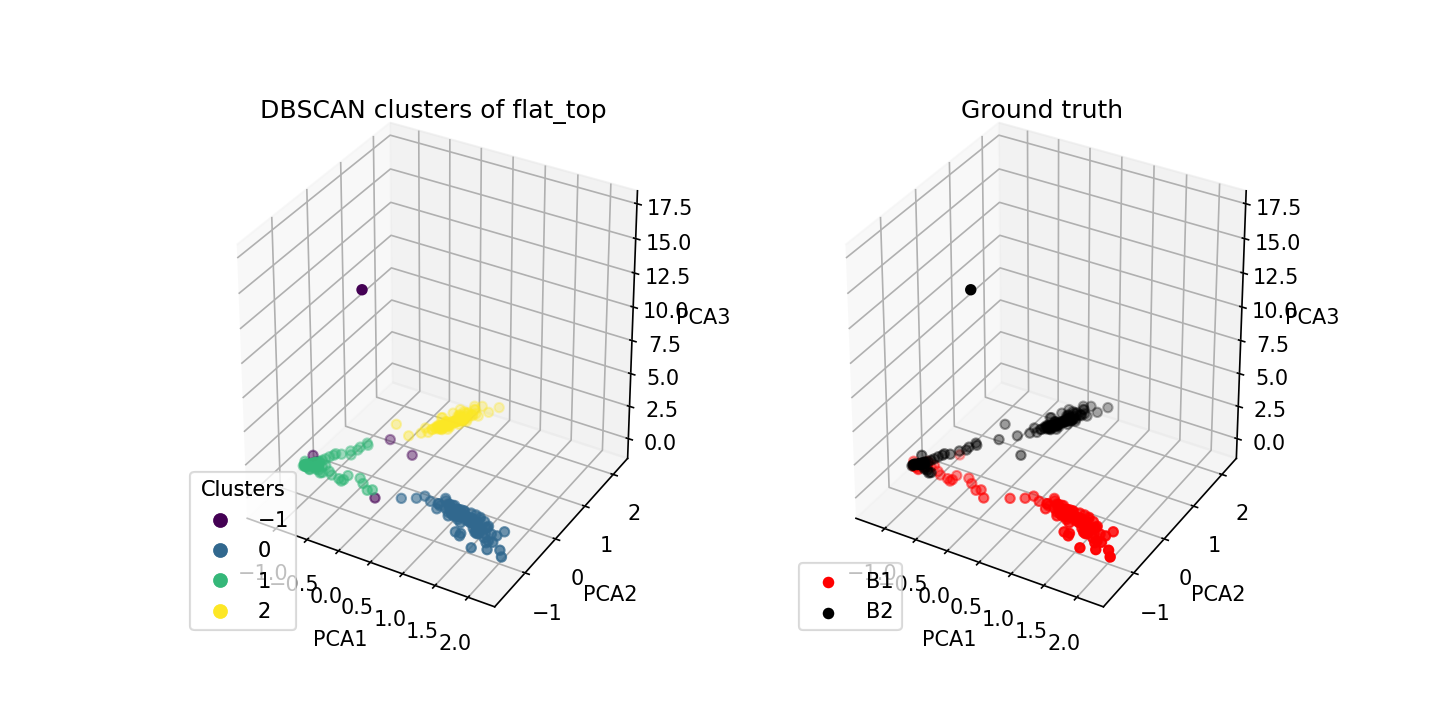

start_squeeze - PCA
	Average accuracy = 78.88%

	Cluster -1 has 8.26% (19 / 230) of the losses, of which:
			63.16% are B1, 	36.84% are B2

		Timestamps std dev = 2263414 days, 15:12:17.634864
		Timestamps mean = 2018-08-10 00:31:20.150526762

	Cluster 0 has 36.09% (83 / 230) of the losses, of which:
			100.00% are B1, 	0.00% are B2

		Timestamps std dev = 1752288 days, 5:37:35.061449
		Timestamps mean = 2018-08-21 04:37:22.241927624

	Cluster 1 has 18.26% (42 / 230) of the losses, of which:
			47.62% are B1, 	52.38% are B2

		Timestamps std dev = 2355841 days, 12:46:07.521179
		Timestamps mean = 2018-08-25 19:02:29.624523640

	Cluster 2 has 37.39% (86 / 230) of the losses, of which:
			0.00% are B1, 	100.00% are B2

		Timestamps std dev = 1753288 days, 3:17:28.240080
		Timestamps mean = 2018-08-21 05:16:44.015929937



<IPython.core.display.Javascript object>


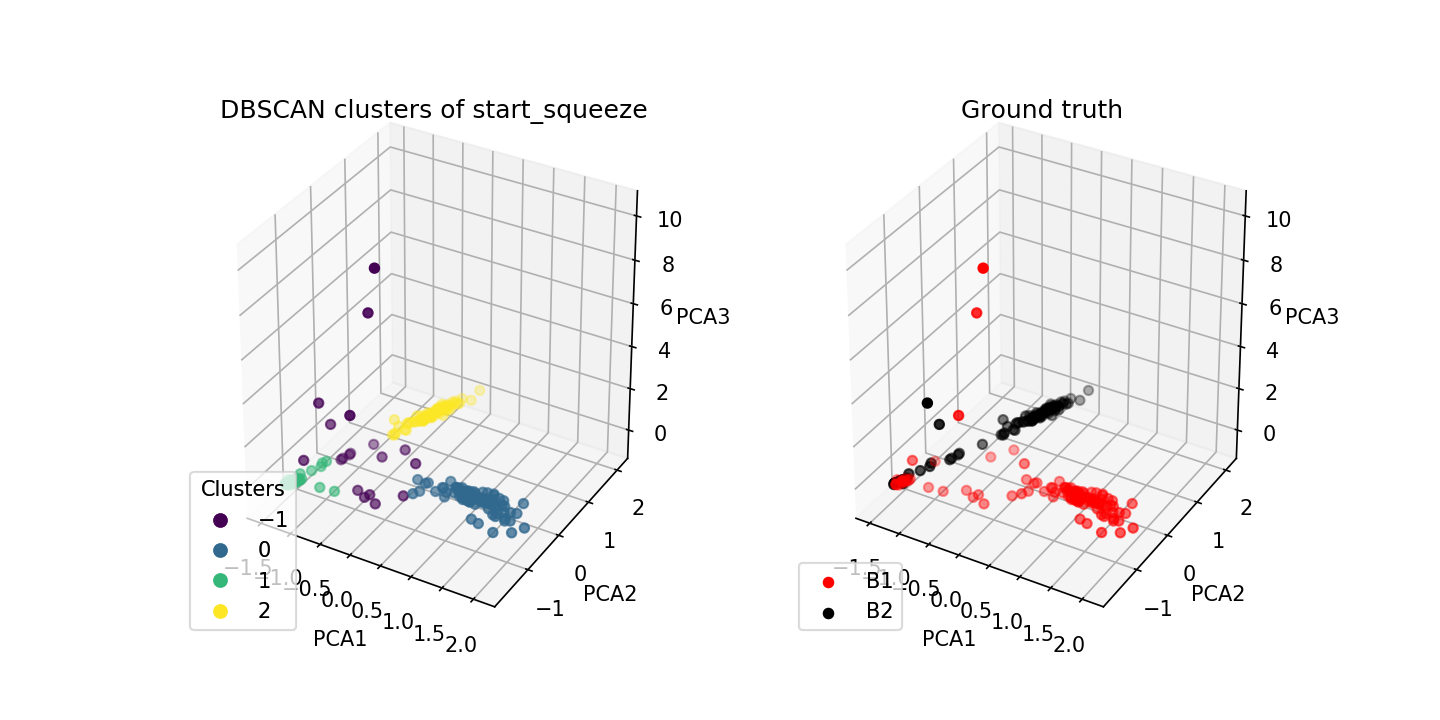

start_adjust - PCA
	Average accuracy = 75.21%

	Cluster -1 has 24.58% (59 / 240) of the losses, of which:
			49.15% are B1, 	50.85% are B2

		Timestamps std dev = 2310822 days, 18:43:29.733541
		Timestamps mean = 2018-08-23 14:31:07.758983374

	Cluster 0 has 26.67% (64 / 240) of the losses, of which:
			50.00% are B1, 	50.00% are B2

		Timestamps std dev = 2334965 days, 7:54:17.414384
		Timestamps mean = 2018-08-22 23:31:06.659687757

	Cluster 1 has 24.58% (59 / 240) of the losses, of which:
			100.00% are B1, 	0.00% are B2

		Timestamps std dev = 1469039 days, 22:42:35.965564
		Timestamps mean = 2018-08-19 16:52:29.067966223

	Cluster 2 has 24.17% (58 / 240) of the losses, of which:
			0.00% are B1, 	100.00% are B2

		Timestamps std dev = 1406715 days, 16:17:24.168191
		Timestamps mean = 2018-08-19 00:10:15.396379471



<IPython.core.display.Javascript object>


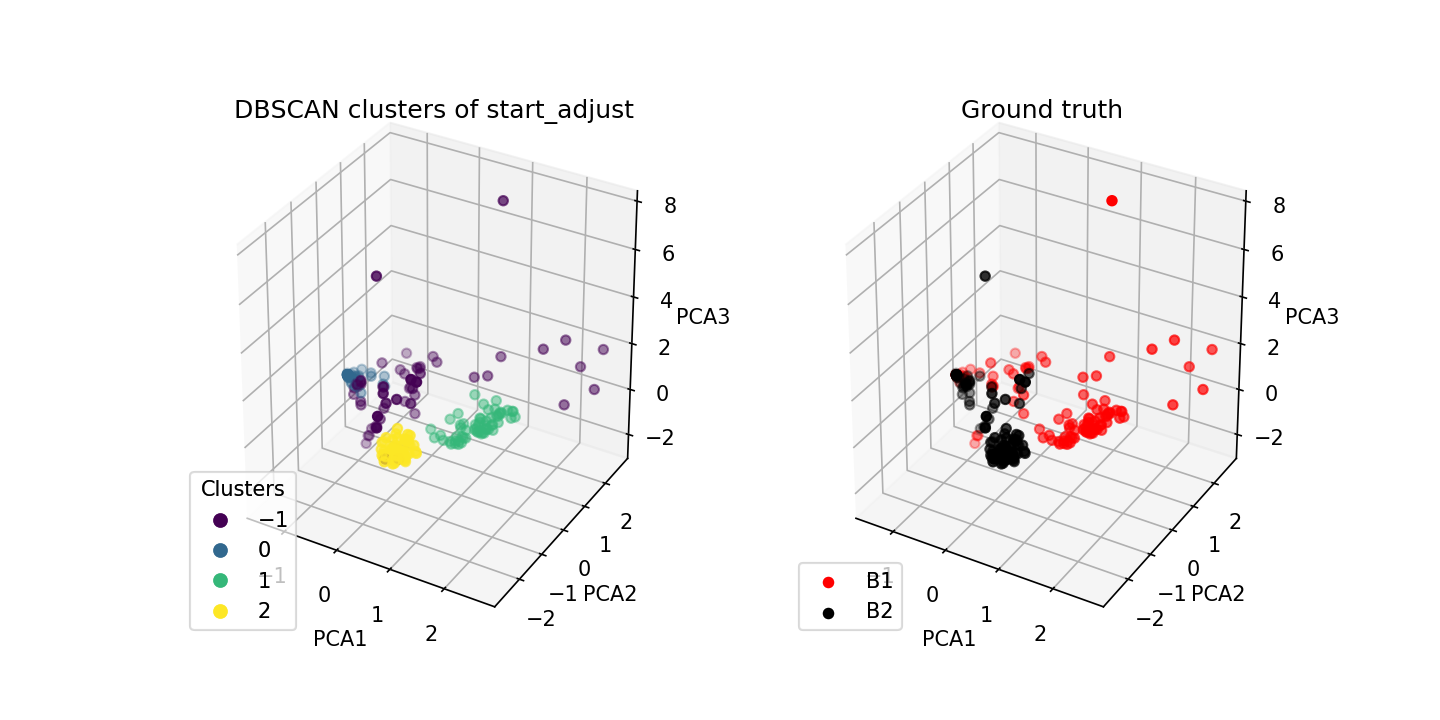

In [32]:
for phaseName, lossDf in lossDfsPCA.items():
    print(f'{phaseName} - PCA')
    dbscanAnalysis(dbscan, lossDf, timestamps[phaseName], phaseName)

## Linear classifier

Here we deliberately use linear classifiers because we are interested in finding asymmetry if it exists.  The worse the classifier does at linearly separating the data, the more symmetric the data.  The better the classisfier does at linearly separating the data, the more asymmetric the data.

### Helper functions

In [33]:
def plotClassifierPlane(lossDf, phaseName, clf):
    """ Scatter plots losses in `lossDf` and includes decision boundary plane found by the linear classifier `clf`.
    
    Parameters
    ----------
    lossDf : DataFrame of floats
        Loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    phaseName : str
    clf : sklearn.svm.LinearSVC object
        Note: the object must have been fitted (i.e. its fit( ) method must have been called).  Used to obtain the plane.
    """
    # Note: https://matplotlib.org/mpl_toolkits/mplot3d/faq.html#my-3d-plot-doesn-t-look-right-at-certain-viewing-angles
    #"This is probably the most commonly reported issue with mplot3d. The problem is that – from some viewing angles – a 
    #3D object would appear in front of another object, even though it is physically behind it."

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatterPlotLosses(lossDf, f"Linear SVC decision plane on {phaseName}", ax)
    
    # ax.plot_surface([0,0], [1,1], [1,1])
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
#     zlim = ax.get_zlim() - for having same scale on axes as original plot (before adding the surface)
    x, y = np.meshgrid(np.linspace(xlim[0], xlim[1], 2),
                         np.linspace(ylim[0], ylim[1], 2))
    z = lambda x, y: (-clf.intercept_[0]-clf.coef_[0][0]*x-clf.coef_[0][1]*y) / clf.coef_[0][2]
    
#     ax.set_zlim(zlim) - for having same scale on axes as original plot (before adding the surface)
    ax.plot_surface(x, y, z(x,y), alpha=0.9)

In [34]:
def linearClassifierAnalysis(clf, lossDf, timestamps, phaseName):
    """ Fits a linear classifier to `lossDf` and displays clustering info - where in this case the "clusters" are actually
    the two sides of the decision boundary.
    
    Plots are only done if `lossDf` is 3D.
    
    Parameters
    ----------
    clf : sklearn.svm.LinearSVC object
    lossDf : DataFrame of floats
        Loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    timestamps : Series of float
            Timestamps corresponding to each training sample in lossDf
    phaseName : str
    """
    samplesCount = len(lossDf)
    
    # make ground truth labels used by the linear classifier - where each element of the list corresponds to a row
    #     1 means the corresponding row is a B1 loss
    #     2 means the corresponding row is a B2 loss
    classes = ([1] * (samplesCount // 2)) + ([2] * (samplesCount // 2))

    # test that class 1 corresponds to 'B1' index in the dataframe, class 2 corresponds to 'B2'
    for idx, c in enumerate(classes):
        assert (c == 1 and lossDf.iloc[idx].name[0] == 'B1') or (c == 2 and lossDf.iloc[idx].name[0] == 'B2')

    clf.fit(lossDf, classes)

    result = ClusteringResult(clf.predict(lossDf), timestamps)
    result.describe()
    print(f'score = {clf.score(lossDf, classes)}\n') # also gives accuracy.  TODO ask - numbers are slightly different.  due to floats?
    if is3D(lossDf):
        plotClassifierPlane(lossDf, phaseName, clf)

### Analysis

In [35]:
clf = svm.LinearSVC(dual=False) # docs: "Prefer dual=False when n_samples > n_features"
#TODO ask - should you standardise before SVM?
#I think so: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
#A Practical Guide to Support Vector CLassification: The main advantage of scaling is to avoid attributes in greater numeric
#ranges dominating those in smaller numeric ranges. Another advantage is to avoid numerical diculties during the calculation. 
#Because kernel values usually depend on the inner products of feature vectors, e.g. the linear kernel and the polynomial 
#ker- nel, large attribute values might cause numerical problems. We recommend linearly scaling each attribute to the range 
#[-1,+1] or [0,1].
# TODO ask about this - the authors are recommending to scale linearly but I have standardised (i.e. changing the distribution
# to unit variance, zero mean.)

#### Full feature-space

In [36]:
for phaseName, lossDf in lossDfs.items():
    print(phaseName)
    linearClassifierAnalysis(clf, lossDf, timestamps[phaseName], phaseName)

start_ramp
	Average accuracy = 100.00%

	Cluster 1 has 50.00% (151 / 302) of the losses, of which:
			100.00% are B1, 	0.00% are B2

		Timestamps std dev = 1987396 days, 10:12:02.497255
		Timestamps mean = 2018-08-20 12:55:09.853046656

	Cluster 2 has 50.00% (151 / 302) of the losses, of which:
			0.00% are B1, 	100.00% are B2

		Timestamps std dev = 1987396 days, 10:12:02.497255
		Timestamps mean = 2018-08-20 12:55:09.853046656

score = 1.0

flat_top
	Average accuracy = 100.00%

	Cluster 1 has 50.00% (151 / 302) of the losses, of which:
			100.00% are B1, 	0.00% are B2

		Timestamps std dev = 1992428 days, 20:20:17.164222
		Timestamps mean = 2018-08-21 01:27:36.269337654

	Cluster 2 has 50.00% (151 / 302) of the losses, of which:
			0.00% are B1, 	100.00% are B2

		Timestamps std dev = 1992428 days, 20:20:17.164222
		Timestamps mean = 2018-08-21 01:27:36.269337654

score = 1.0

start_squeeze
	Average accuracy = 99.57%

	Cluster 1 has 50.43% (116 / 230) of the losses, of which:
			99.1

#### PCA features

start_ramp - PCA
	Average accuracy = 90.52%

	Cluster 1 has 44.70% (135 / 302) of the losses, of which:
			94.81% are B1, 	5.19% are B2

		Timestamps std dev = 1908856 days, 18:14:32.473280
		Timestamps mean = 2018-08-21 04:49:13.146963120

	Cluster 2 has 55.30% (167 / 302) of the losses, of which:
			13.77% are B1, 	86.23% are B2

		Timestamps std dev = 2047424 days, 5:09:23.889331
		Timestamps mean = 2018-08-20 00:03:55.334011555

score = 0.9006622516556292



<IPython.core.display.Javascript object>


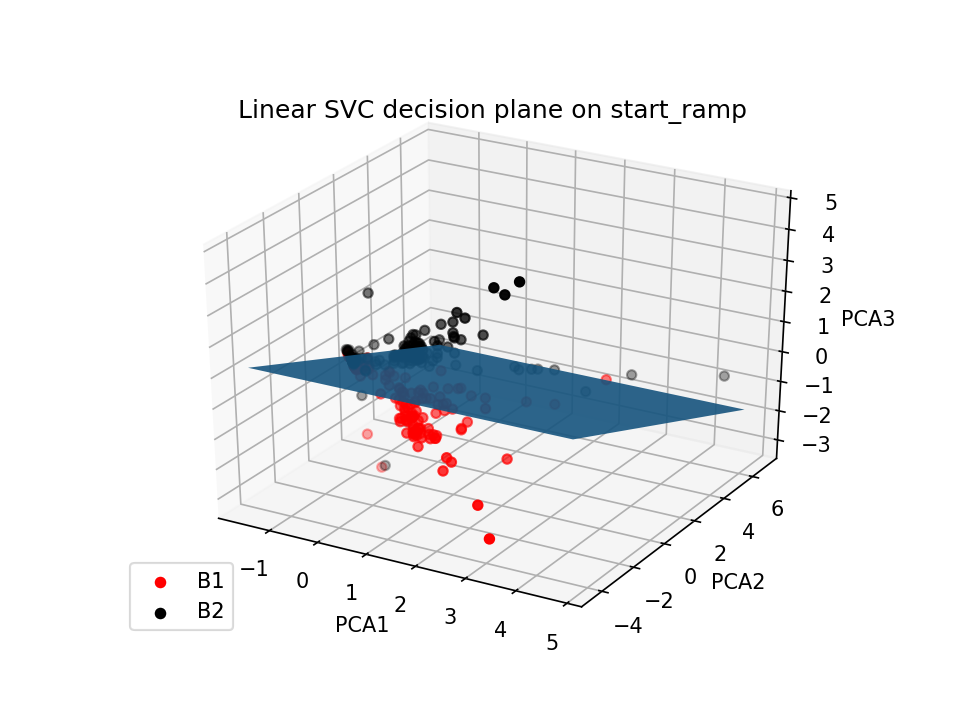

flat_top - PCA
	Average accuracy = 95.40%

	Cluster 1 has 48.68% (147 / 302) of the losses, of which:
			96.60% are B1, 	3.40% are B2

		Timestamps std dev = 1986283 days, 19:49:37.638251
		Timestamps mean = 2018-08-21 00:51:18.254830122

	Cluster 2 has 51.32% (155 / 302) of the losses, of which:
			5.81% are B1, 	94.19% are B2

		Timestamps std dev = 1998234 days, 23:44:13.155930
		Timestamps mean = 2018-08-21 02:02:01.870193243

score = 0.9536423841059603



C:\Users\mvell\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


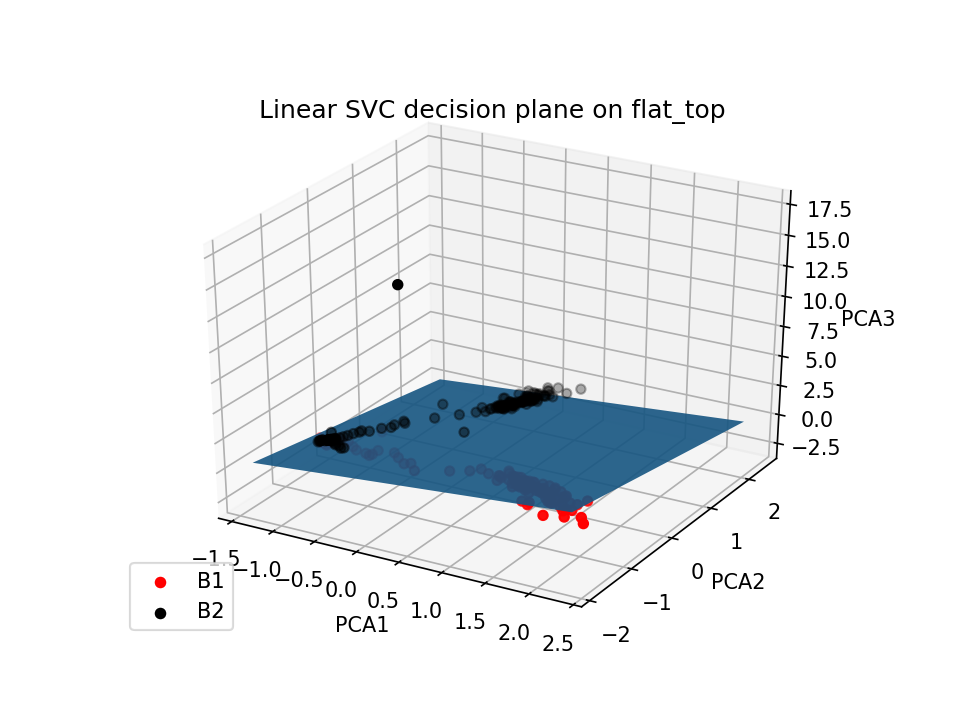

start_squeeze - PCA
	Average accuracy = 93.16%

	Cluster 1 has 44.35% (102 / 230) of the losses, of which:
			98.04% are B1, 	1.96% are B2

		Timestamps std dev = 1905105 days, 22:57:02.888703
		Timestamps mean = 2018-08-20 20:55:12.552058458

	Cluster 2 has 55.65% (128 / 230) of the losses, of which:
			11.72% are B1, 	88.28% are B2

		Timestamps std dev = 1965266 days, 11:36:52.738665
		Timestamps mean = 2018-08-21 07:38:12.017421961

score = 0.9260869565217391



C:\Users\mvell\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


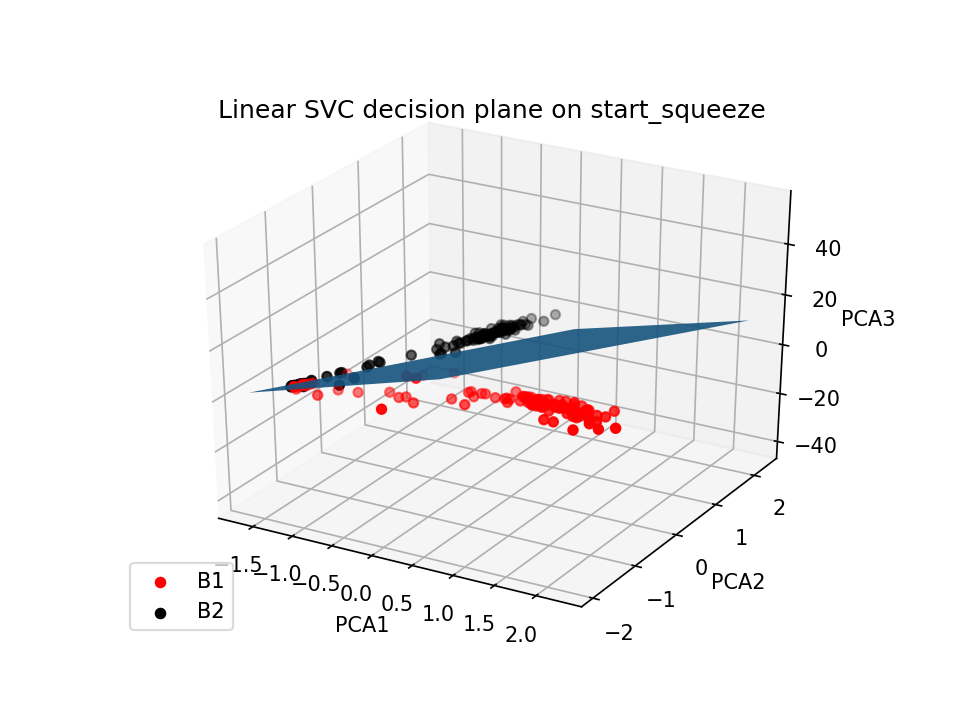

start_adjust - PCA
	Average accuracy = 90.07%

	Cluster 1 has 57.50% (138 / 240) of the losses, of which:
			84.06% are B1, 	15.94% are B2

		Timestamps std dev = 2008020 days, 12:36:11.169093
		Timestamps mean = 2018-08-21 20:27:56.387101412

	Cluster 2 has 42.50% (102 / 240) of the losses, of which:
			3.92% are B1, 	96.08% are B2

		Timestamps std dev = 1848903 days, 9:03:16.064658
		Timestamps mean = 2018-08-20 17:05:19.711568594

score = 0.8916666666666667



C:\Users\mvell\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


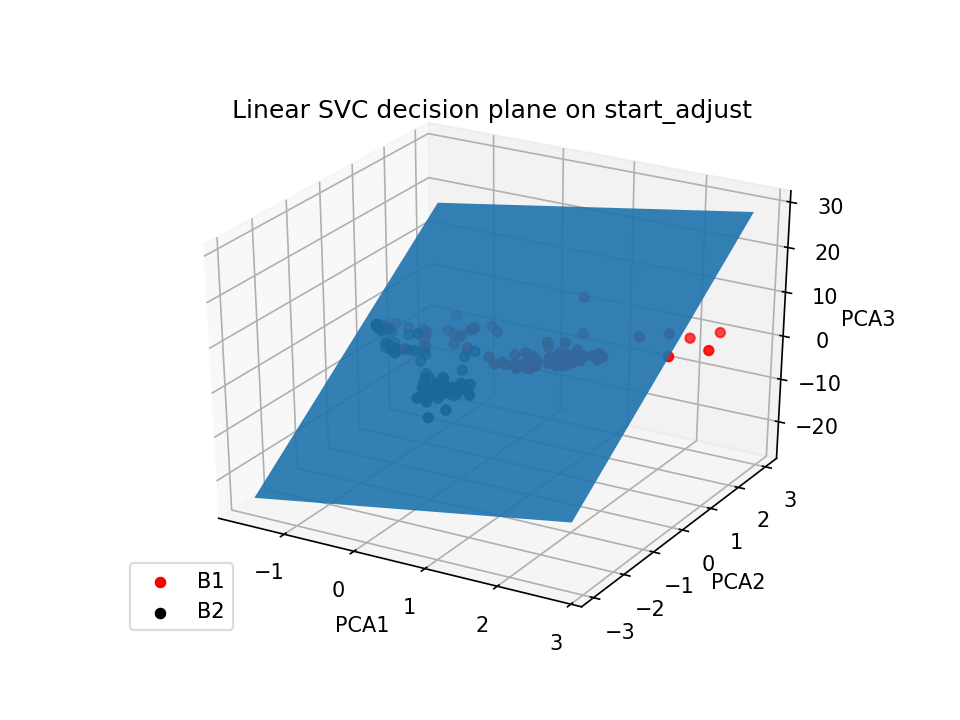

In [37]:
for phaseName, lossDf in lossDfsPCA.items():
    print(f'{phaseName} - PCA')
    linearClassifierAnalysis(clf, lossDf, timestamps[phaseName], phaseName)

## Exploratory plots

C:\Users\mvell\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


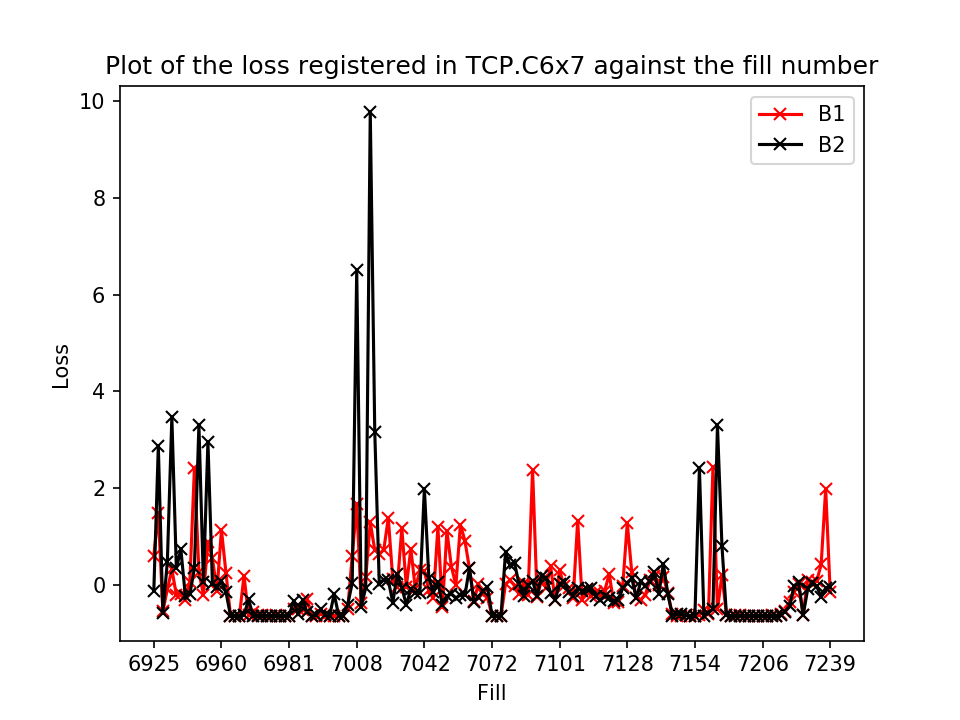

In [38]:
# Data
df = pd.DataFrame({
    'B1': lossDfs['start_ramp'].loc['B1']['TCP.C6x7'],
    'B2': lossDfs['start_ramp'].loc['B2']['TCP.C6x7']
})
 
# multiple line plot
fig, ax = plt.subplots()
ax.plot('B1', data=df, marker='x', color='red')
ax.plot('B2', data=df, marker='x', color='black')
ax.set(xlabel='Fill', ylabel='Loss', title='Plot of the loss registered in TCP.C6x7 against the fill number')
ax.legend()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=15.0))  # set freqeuency of x-axis labels (fill numbers)

In [39]:
# plt.figure(figsize=(10, 36))
# ncols = 3;
# nrows = math.ceil(startRampLosses.shape[1] / ncols)
# i = 1;
# for column in startRampLosses:
#     # Data
#     df = pd.DataFrame({
#         'B1': startRampLosses.loc['B1'][column],
#         'B2': startRampLosses.loc['B2'][column]
#     })
 
#     plt.subplot(nrows, ncols, i)
# #     plt.yscale('log') # TODO - ask: no need for log scale since we have standardised the data now?
# #     plt.yscale('symlog') - since we have negative values now after standardising
#     plt.plot('B1', data=df, marker='x', color='red')
#     plt.plot('B2', data=df, marker='x', color='black')
#     plt.title(column)

    
#     i = i + 1
    

# plt.tight_layout()